In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import blip_analysis as ba
import exp_blip_models as ebm
import numpy as np
import daskify
from scipy.stats import ttest_ind
import pickle
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import trange, tqdm
import dask
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import matplotlib
import copy
from scipy.stats import nbinom, skewnorm, mannwhitneyu, poisson, chi2_contingency, norm
import statsmodels.api as sm
import time
from sklearn.cluster import OPTICS
import importlib
importlib.reload(ebm)

b
b


<module 'exp_blip_models' from '/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/exp_blip_models.py'>

In [2]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

Found odour 1
Found odour 3
Found odour 5


In [ ]:
def plot_mean_and_std(ax, data, axis=-1, xs=None):
    mean_data = data.mean(axis=axis)
    std_data = data.std(axis=axis)
    if xs is None:
        xs = np.arange(len(mean_data))
    ax.plot(xs, mean_data)
    ax.fill_between(xs, mean_data-std_data, mean_data+std_data, alpha=0.5)
def set_global_ylims(axs, ylim=None):
    if ylim is None:
        ylims = [ax.get_ylim() for ax in axs]
        ylim = (np.min([y[0] for y in ylims]), np.max([y[1] for y in ylims]))
    for ax in axs:
        ax.set_ylim(ylim)

def split_and_classify(usrt_scattered, trial_indexes, scaled=True, shuffle=False, unit_count=130, pcad=True, pca_count=1, classifier=LinearSVC, classifier_params={}):
    unit_indexes = np.random.choice(range(130), replace=False, size=unit_count)
    train, test = ba.split_bs_data(usrt_scattered[unit_indexes])
    train_sum = train.sum(axis=-1)[:, trial_indexes].reshape(unit_count, -1).T
    test_sum = test.sum(axis=-1)[:, trial_indexes].reshape(unit_count, -1).T
    y_train = np.hstack([[i for j in range(60)] for i in trial_indexes])
    y_test = trial_indexes
    
    if scaled:
        scaler = StandardScaler()
        train_sum = scaler.fit_transform(train_sum)
        test_sum = scaler.transform(test_sum)
    svm = classifier(**classifier_params)
    if shuffle:
        np.random.shuffle(y_train)
    svm.fit(train_sum, y_train)
    return svm.score(test_sum, y_test), svm.predict(test_sum)

def dask_svm(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    svm = RandomForestClassifier()
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    return pred, y_test

def generate_noisy_data(models, noise_level=10,repeats=60, method='add', unit_var_scale=1):
    all_pred_firings = []
    for model in models:
        pred_firings= []
        if len(model.pred_resp) != 32:
            model.fit()
        for i in range(repeats):
            if method == 'add':
                pred_firing  = model.pred_resp + norm.rvs(0, noise_level, size=32)
            elif method == 'unit_var':
                pred_firing = model.pred_resp + np.array([norm.rvs(0, j, size=1)[0]*unit_var_scale for j in model.unit_sr_var])
            pred_firings.append(pred_firing)
        all_pred_firings.append(pred_firings)
    all_pred_firings = np.array(all_pred_firings)
#    ys = [i for j in range(60) for i in range(32)]
    return all_pred_firings

def generate_and_dask(models, noise_level=10, classifier_repeats=100, method='unit_var', unit_var_scale=1, wait=True, data_repeats=60):
    X = generate_noisy_data(models, noise_level=noise_level, method=method, unit_var_scale=unit_var_scale, repeats=data_repeats).reshape(len(models), -1).T
    ys = [i for j in range(data_repeats) for i in range(32)]
    y_scatter = dasked.client.scatter(ys)
    X_scattered = dasked.client.scatter(X)
    
    delayeds = [dask.delayed(dask_svm)(X_scattered, y_scatter, 32) for i in range(classifier_repeats)]
    dask_outs = dasked.client.compute(delayeds)
    dasked.current_futures = dask_outs
    


In [ ]:
### Set up the dask cluster
dasked = daskify.Daskified(memory="16GB")
dasked.start_cluster()

## Checking out the bin weightings first


### Generating the bin weightings

In [9]:
diff_models1 = pickle.Unpickler(open('../Fig4/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Fig4/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Fig4/230320_diff_models3.pkl', 'rb')).load()
onset_models1 = pickle.Unpickler(open('../Fig4/230320_onset_models1.pkl', 'rb')).load()
conc_models1 = pickle.Unpickler(open('../Fig4/230320_conc_models1.pkl', 'rb')).load()

# unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
# good_indexes = ba.get_stable_resp_indexes()

In [10]:
model = diff_models1[0]
bin_weights1 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models1])
bin_weights2 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models2])
bin_weights3 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models3])


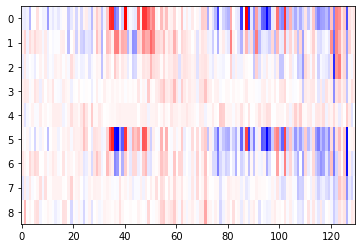

In [11]:
plt.imshow(bin_weights1.mean(axis=1).T, aspect='auto', cmap='bwr', interpolation='none')
glyphs = ba.get_glyphs()

74
13
8
6
7
16
6
66
12
13
10
5
5
8
11
95
5
7
8
5
5
5


Text(0.5, 0, 'Cell')

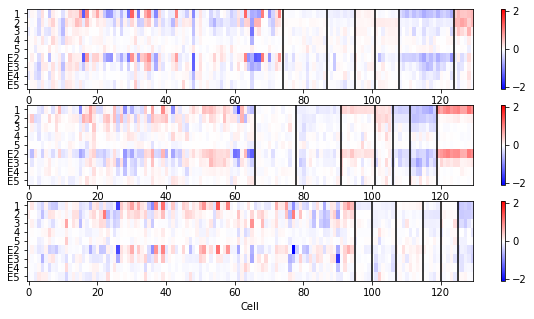

In [18]:
# opts = OPTICS()
# opts.fit(bin_weights1.mean(axis=1))
# counts = []
# for i in np.unique(opts.labels_):
#     print(len(np.where(opts.labels_ == i)[0]))
#     counts.append(len(np.where(opts.labels_ == i)[0]))
# sorted_args = np.argsort(opts.labels_)
# plt.imshow(bin_weights1.mean(axis=1).T[:, sorted_args], aspect='auto', cmap='bwr', interpolation='none')
# for i in np.cumsum(counts)[:-1]:
#     plt.axvline(i, color='k')
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
vmax = np.max(np.abs([bin_weights1.mean(axis=1), bin_weights2.mean(axis=1), bin_weights3.mean(axis=1)]))
for index, bin_weights in enumerate([bin_weights1, bin_weights2, bin_weights3]):
    opts = OPTICS()
    opts.fit(bin_weights.mean(axis=1))
    counts = []
    #vmax = np.max(abs(bin_weights.mean(axis=1)))
    for i in np.unique(opts.labels_):
        print(len(np.where(opts.labels_ == i)[0]))
        counts.append(len(np.where(opts.labels_ == i)[0]))
    sorted_args = np.argsort(opts.labels_)
    im = ax[index].imshow(bin_weights.mean(axis=1).T[:, sorted_args], aspect='auto', cmap='bwr', interpolation='none', vmax=vmax, vmin=-vmax)
    for i in np.cumsum(counts)[:-1]:
        ax[index].axvline(i, color='k')
    plt.colorbar(im, ax=ax[index])
    ax[index].set_yticks(range(9))
    ax[index].set_yticklabels(list(range(1, 6)) + ['E2', 'E3', 'E4', 'E5'])
    ax[index].set_ylim(8.5, -0.5)
ax[-1].set_xlabel('Cell')

[[1.         0.92436564]
 [0.92436564 1.        ]]


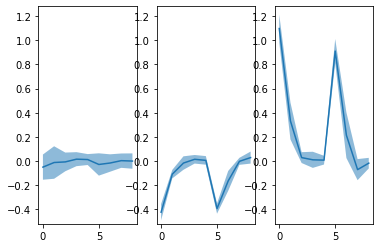

In [8]:
cluster_bins = [bin_weights1.mean(axis=1).T[:, np.where(i == opts.labels_)[0]] for i in np.unique(opts.labels_)]
fig, ax = plt.subplots(1, 3)
plot_mean_and_std(ax[0], cluster_bins[1])
plot_mean_and_std(ax[1], cluster_bins[2])
plot_mean_and_std(ax[2], cluster_bins[3])
set_global_ylims(ax)
print(np.corrcoef(cluster_bins[1].mean(axis=1), cluster_bins[2].mean(axis=1)))

360
6
24


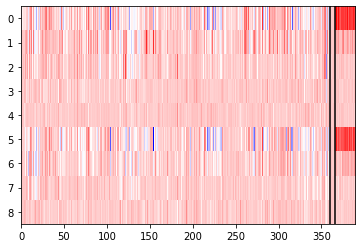

In [9]:
joined_weights = np.concatenate([bin_weights1, bin_weights2, bin_weights3])
joined_opts = OPTICS()
joined_opts.fit(joined_weights.mean(axis=1))

joined_counts = []
for i in np.unique(joined_opts.labels_):
    print(len(np.where(joined_opts.labels_ == i)[0]))
    joined_counts.append(len(np.where(joined_opts.labels_ == i)[0]))

joined_sorted_args = np.argsort(joined_opts.labels_)
plt.imshow(joined_weights.mean(axis=1).T[:, joined_sorted_args], aspect='auto', cmap='bwr', interpolation='none')
for i in np.cumsum(joined_counts)[:-1]:
    plt.axvline(i, color='k')


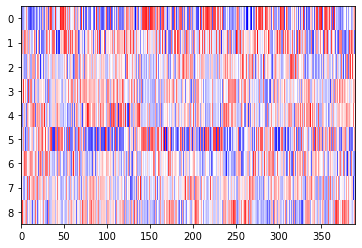

In [10]:
scaler =  StandardScaler()
joined_weights_scaled = scaler.fit_transform(joined_weights.mean(axis=1).T)
pca_scaled = PCA(n_components=9)
joined_pcad = pca_scaled.fit_transform(joined_weights_scaled.T)
plt.imshow(joined_weights_scaled, aspect='auto', cmap='bwr', interpolation='none')
pca = PCA(n_components=9)
pcad_norm = pca.fit_transform(joined_weights.mean(axis=1))

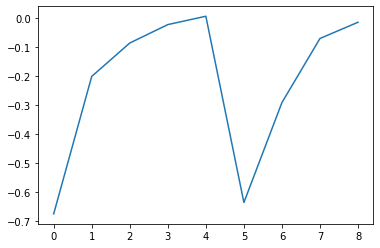

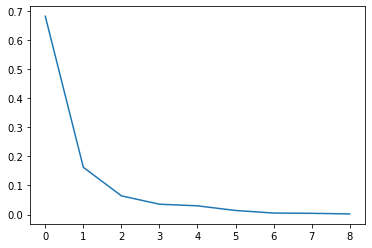

In [11]:
plt.plot(pca.components_[0])
plt.figure()
plt.plot(pca.explained_variance_ratio_)

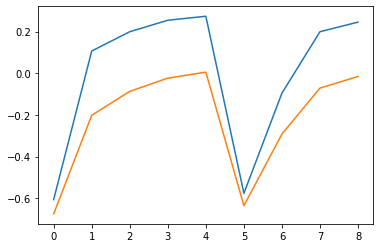

In [12]:
plt.plot(pca_scaled.components_[0]*-1)
plt.plot(pca.components_[0])

67
7
7
7
5
8
15
7
7
62
21
9
11
7
9
11
92
8
5
6
6
7
6


Text(0.5, 0, 'Cell')

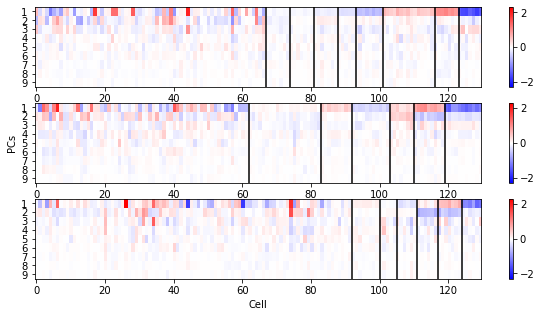

In [26]:
pca1 = PCA(n_components=9)
pcad_norm1 = pca1.fit_transform(bin_weights1.mean(axis=1))
pca2 = PCA(n_components=9)
pcad_norm2 = pca2.fit_transform(bin_weights2.mean(axis=1))
pca3 = PCA(n_components=9)
pcad_norm3 = pca3.fit_transform(bin_weights3.mean(axis=1))
vmax = np.max(np.abs([pcad_norm1, pcad_norm2, pcad_norm3]))
#plt.imshow(pcad_norm1.T, aspect='auto', cmap='bwr', interpolation='none', vmax=vmax, vmin=-vmax)
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
for index, bin_weights in enumerate([pcad_norm1, pcad_norm2, pcad_norm3]):
    opts = OPTICS()
    opts.fit(bin_weights[:, :2])
    counts = []
    #vmax = np.max(abs(bin_weights.mean(axis=1)))
    for i in np.unique(opts.labels_):
        print(len(np.where(opts.labels_ == i)[0]))
        counts.append(len(np.where(opts.labels_ == i)[0]))
    sorted_args = np.argsort(opts.labels_)
    im = ax[index].imshow(bin_weights.T[:, sorted_args], aspect='auto', cmap='bwr', interpolation='none', vmax=vmax, vmin=-vmax)
    for i in np.cumsum(counts)[:-1]:
        ax[index].axvline(i, color='k')
    plt.colorbar(im, ax=ax[index])
    ax[index].set_yticks(range(9))
    ax[index].set_yticklabels(range(1, 10))
    ax[index].set_ylim(8.5, -0.5)
ax[1].set_ylabel('PCs')
ax[-1].set_xlabel('Cell')

### Making weightings from reduced number of components

In [79]:
def return_models(bin_weights, base_models, saved_components=1):
    pca = PCA(n_components=9)
    pcad_bw = pca.fit_transform(bin_weights.mean(axis=1))
    pcad_bw[:, saved_components:] = 0
    returned_weights = pca.inverse_transform(pcad_bw)
    returned_models = [copy.deepcopy(i) for i in base_models]
    [i.fit() for i in returned_models]
    threshes = [i.opt_out.x[-1] for i in returned_models]
    joined_weights = [list(returned_weights[i]) + [threshes[i]] for i in range(len(returned_weights))]
    [j.fit(W=joined_weights[i]) for i, j in enumerate(returned_models)]
    return returned_models


### Makes models with x components for each bin from each PC
all_returned_models1 = [return_models(bin_weights1, diff_models1, i) for i in trange(9)]
all_returned_models2 = [return_models(bin_weights2, diff_models2, i) for i in trange(9)]
all_returned_models3 = [return_models(bin_weights3, diff_models3, i) for i in trange(9)]


100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


In [70]:
ys = [i for j in range(60) for i in range(32)]
y_scatter = dasked.client.scatter(ys)

In [26]:
### Generate noisy data and run classifiers on them with different noise levels
all_futures = []
for model_type in [all_returned_models1, all_returned_models2, all_returned_models3]:
    for model in tqdm(model_type, position=0, leave=False):
        for i in range(20):
            generate_and_dask(model, method='add', noise_level=i)
            all_futures.append(dasked.current_futures)
all_futures = np.concatenate(all_futures)
dasked.current_futures = all_futures
dasked.current_futures = list(dasked.current_futures)

# Do the same for the diff models
generate_and_dask(diff_models1)

### Collecting the data from the dask task

In [29]:
res = dasked.collect_results()

In [31]:
print(np.array(res).shape)

(100, 2, 32)


In [118]:
res = np.array(res).reshape(20, 100, 2, 32)
preds1 = res[:, :, 0]
trues1 = res[:, :, 1]
cms1 = [confusion_matrix(trues1[i].flatten(), preds1[i].flatten(), labels=range(32), normalize='true') for i in range(20)]

In [63]:
#print(np.array(res).reshape(20, 100, 2, 32))
## Take the results from the dasked futures ans reshape them into 3 odours x 9 PCs x 20 noise levels x 100 trials x 2 (preds, trues) x 32 stimuli types
res = np.array(res).reshape(3,9, 20, 100, 2, 32)
preds1 = np.array(res)[0, :, :, :, 0]
preds2 = np.array(res)[1, :, :, :, 0]
preds3 = np.array(res)[2, :, :, :, 0]

trues1 = np.array(res)[0, :, :, :, 1]
trues2 = np.array(res)[1, :, :, :, 1]
trues3 = np.array(res)[2, :, :, :, 1]

cms1 = np.array([[confusion_matrix(trues1[j, i].flatten(), preds1[j, i].flatten(), labels=range(32), normalize='true') for i in range(20)] for j in range(9)])
cms2 = np.array([[confusion_matrix(trues2[j, i].flatten(), preds2[j, i].flatten(), labels=range(32), normalize='true') for i in range(20)] for j in range(9)])
cms3 = np.array([[confusion_matrix(trues3[j, i].flatten(), preds3[j, i].flatten(), labels=range(32), normalize='true') for i in range(20)] for j in range(9)])

In [102]:
np.save('cms1.npy', cms1)
np.save('cms2.npy', cms2)
np.save('cms3.npy', cms3)


### Loading the data back in

In [11]:
### Load in the results from the full classifiers and the confusion matrices from the reduced pc classifiers
true_classifiers = pickle.Unpickler(open('../Fig3/230315_full_classifier_RFs.pkl', 'rb')).load()
preds = true_classifiers[:, :, 1]
preds = np.array([np.hstack(i) for i in preds])
trues = [i for j in range(100) for i in range(32)]
cm_true1 = confusion_matrix(trues, preds[0], labels=range(32), normalize='true')
cm_true2 = confusion_matrix(trues, preds[1], labels=range(32), normalize='true')
cm_true3 = confusion_matrix(trues, preds[2], labels=range(32), normalize='true')
cms1 = np.load('cms1.npy')
cms2 = np.load('cms2.npy')
cms3 = np.load('cms3.npy')

In [19]:
### Checking the correlation and the summed squared error between the odour classifiers
print(np.corrcoef([cm_true1.flatten(), cm_true2.flatten(), cm_true3.flatten()]))
print([np.sum((i - j)**2) for i in [cm_true1, cm_true2, cm_true3] for j in [cm_true1, cm_true2, cm_true3]])

[[1.         0.76200179 0.79754447]
 [0.76200179 1.         0.8703875 ]
 [0.79754447 0.8703875  1.        ]]
[0.0, 2.886, 2.4516, 2.886, 0.0, 1.5004000000000004, 2.4516, 1.5004000000000004, 0.0]


(9, 20)
[ 0  5 10  8 11 10  9  9 12]
0.8644156345561244
1.6804000000000001


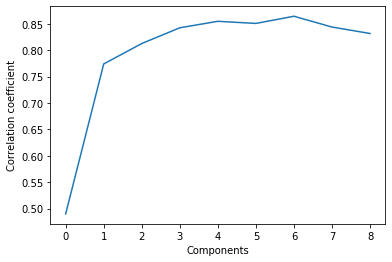

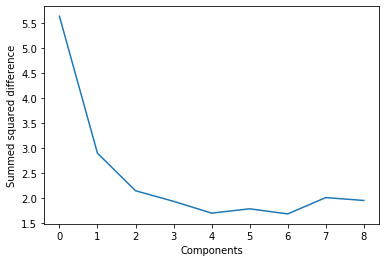

In [20]:
### Checking the correlation and the summed squared error between the odour classifiers and the reduced pc classifiers

corrs1 = np.array([[np.corrcoef(cm_true1.flatten(), i.flatten())[0, 1] for i in j] for j in cms1])
corrs2 = np.array([[np.corrcoef(cm_true2.flatten(), i.flatten())[0, 1] for i in j] for j in cms2])
corrs3 = np.array([[np.corrcoef(cm_true3.flatten(), i.flatten())[0, 1] for i in j] for j in cms3])

diffs1 = np.array([[np.sum((i - cm_true1)**2) for i in j] for j in cms1])
diffs2 = np.array([[np.sum((i - cm_true2)**2) for i in j] for j in cms2])
diffs3 = np.array([[np.sum((i - cm_true3)**2) for i in j] for j in cms3])

## Plotting the correlation and the summed squared error between the odour classifiers and the reduced pc classifiers
print(corrs1.shape)
plt.plot(np.max(corrs1, axis=1))
print(np.argmax(corrs1, axis=1))
plt.xlabel('Components')
plt.ylabel('Correlation coefficient')
plt.figure()
plt.plot(np.min(diffs1, axis=1))
plt.xlabel('Components')
plt.ylabel('Summed squared difference')
print(np.max(corrs1))
print(np.min(diffs1))

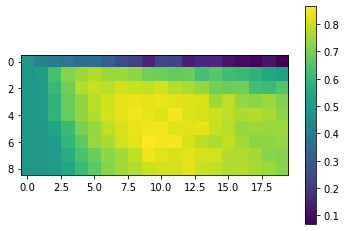

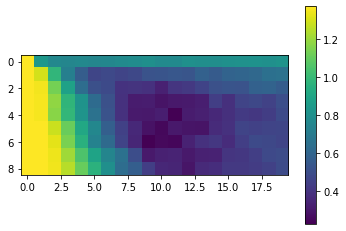

In [17]:
### Checking the correlation and the summed squared error between the reduced pc classifiers
plt.imshow(corrs1)
plt.colorbar()
plt.figure()
plt.imshow(np.log10(diffs1))
plt.colorbar()

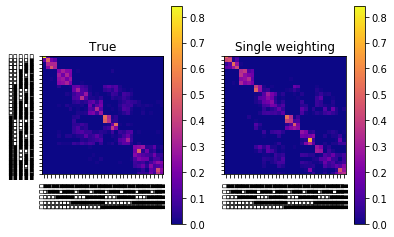

In [77]:
### Plotting the true classifier and the single pc classifier with the best correlation and lowest summed squared error
fig, ax = plt.subplots(1, 2)
vmax = np.max([np.max(cm_true1), np.max(cms1[1, 5])])
im = ax[0].imshow(cm_true1, cmap='plasma', vmax=vmax)
im = ax[1].imshow(cms1[1, 5], cmap='plasma', vmax=vmax)
plt.colorbar(im, ax=ax[1])
ax[0].set_title('True')
ax[1].set_title('Single weighting')
ax[0].set_yticks(range(32))
ax[0].set_yticklabels(glyphs);
ax[1].set_yticks(range(32))
ax[1].set_yticklabels([]);
ax[0].set_xticks(range(32))
ax[0].set_xticklabels(glyphs, rotation=90);
ax[1].set_xticks(range(32))
ax[1].set_xticklabels(glyphs, rotation=90);
plt.colorbar(im, ax=ax[0])

## Looking at the fits of the individual cells

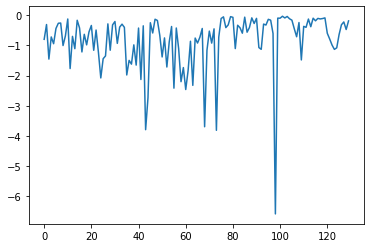

In [24]:
diff_errors1 = np.array([i.fit_score for i in diff_models1])
returned_scores1 = np.array([i.fit_score for i in all_returned_models1[1]])
plt.plot(diff_errors1 - returned_scores1)


In [20]:
print(np.argsort(diff_errors1 - returned_scores1))

[ 98  73  43  68  44  60  55  63  41  58  35  24  59  39  37  11  36 109
  52  61  50  26  23   2  81  21  91 123 122  38  28  18  25  31  16 124
  62  69  57 121  92  51  65  74   8  13  64   4  53 107   3  66 125  12
   0 120  84  49  86  72  97 128  34  17  40  87  56  70 113  42  46  94
  54  71  29  32  77  93 110  33 126 106  27  78  82  83  15  45  96 115
 111  48  47  19  95 105  67 104  75  99  90  10   9 114  88 118 117   1
 127 100  89  85 108  80  76  79 119 103 102 101  14  20 116 112 129  30
  22   6   5   7]


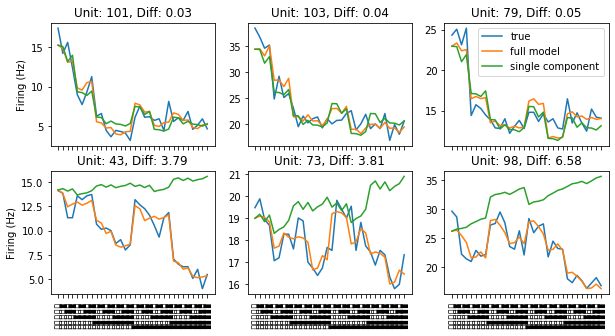

In [25]:
def plot_model_and_single_pred(ax, ui):
    ax.plot(diff_models1[ui].true_resp, label='true')
    ax.plot(diff_models1[ui].pred_resp, label='full model')
    ax.plot(all_returned_models1[1][ui].pred_resp, label='single component')

def plot_comparison_fits(fig, top_indexes, bottom_indexes):
    gs = GridSpec(2, 3)    
    axs_top = [fig.add_subplot(gs[0, i]) for i in range(3)]
    axs_bottom = [fig.add_subplot(gs[1, i]) for i in range(3)]
    [plot_model_and_single_pred(i, j) for i, j in zip(axs_top, top_indexes)];
    [plot_model_and_single_pred(i, j) for i, j in zip(axs_bottom, bottom_indexes)];
    axs_top[0].set_ylabel('Firing (Hz)')
    axs_bottom[0].set_ylabel('Firing (Hz)')
    [i.set_xticks(range(32)) for i in axs_top + axs_bottom];
    [i.set_xticklabels(glyphs, rotation=90) for i in axs_bottom];
    [i.set_xticklabels([]) for i in axs_top];
    return axs_top, axs_bottom

fig = plt.figure(figsize=(10, 5))
diff_diffs = abs(diff_errors1 - returned_scores1)
top_diffs = np.argsort(diff_diffs)[:3]
bottom_diffs = np.argsort(diff_diffs)[-3:]

axs_best, axs_worst = plot_comparison_fits(fig, top_diffs, bottom_diffs)

[i.set_title(f'Unit: {j}, Diff: {diff_diffs[j]:0.2f}') for i, j in zip(axs_best, top_diffs)];
[i.set_title(f'Unit: {j}, Diff: {diff_diffs[j]:0.2f}') for i, j in zip(axs_worst, bottom_diffs)];
axs_best[-1].legend()


In [18]:
print(np.argsort(returned_scores1))

[ 85  88 101  76  90 100  95 103  80  47  79  96  75 119 102  10  48  45
  93 115  99 117  94 105  27 104  34 126  33  72  87  40 114  29  42 113
 116 118 108  70 129  82  54  49  30  84 127  14  51  77 120  78  89 121
  46 112  32  83 125  20   3  74 106 110   7   6  86  31 107  67 111  12
  18 122  15   1  19  91  56  62  81   5  97 123  64 128   9  21   0  23
  92  22 124  50  71  17  66  53  26  38  65  13 109  57   8   4  16  36
  69  37  39  52  35  28   2  11  59  25  41  61  58  24  63  55  60  44
  43  68  73  98]


### Running the joint weighting models

In [24]:
### Generating the joint weight models
importlib.reload(ebm)
jwms = ebm.JoinedWeightModels(unit_usrt1, good_indexes, model_type=ebm.ExponentialCustomTrialArray, model_args=[ebm.trial_arrays['diff_array']], with_mean=True)
jwms_no_mean = ebm.JoinedWeightModels(unit_usrt1, good_indexes, model_type=ebm.ExponentialCustomTrialArray, model_args=[ebm.trial_arrays['diff_array']], with_mean=False)

b


In [127]:
jwms.fit_all()

Optimization terminated successfully.
         Current function value: -1312.877227
         Iterations: 19
         Function evaluations: 64041


In [118]:
jwms_no_mean.fit_all()

Optimization terminated successfully.
         Current function value: -1750.101933
         Iterations: 12
         Function evaluations: 9160


In [129]:
### When the joint weighting is found, fit each model to it
[jwms.models[ui].fit(W=jwms.model_weights[ui]) for ui in range(130)];

In [25]:
### A test to find the difference in speed for each of the fitting methods - Powell is by far the fastest
def jwms_fit_test(jwms_scattered, method, repeats=5):
    times = []
    for i in range(repeats):
        start = time.time()
        jwms_scattered.fit_all(method=method)
        end = time.time()
        times.append(end-start)
    return times
def joined_fit_method_test(usrt_scattered, index_size, method, repeats=5):
    times = []
    all_jwms = []
    for i in range(5):
        st = time.time()
        indexes = np.random.choice(np.arange(len(good_indexes)), index_size, replace=False)
        jwms = ebm.JoinedWeightModels(usrt_scattered, good_indexes[indexes], model_type=ebm.ExponentialCustomTrialArray, model_args=[ebm.trial_arrays['diff_array']])
        jwms.fit_all(method=method)
        end = time.time()
        times.append(end-st)
        all_jwms.append(jwms)
    return all_jwms, times
def dask_jwms_fit(jwms_scattered, method):
    jwms_scattered.fit_all(method=method)
    return jwms_scattered

#all_jwms, times = joined_fit_method_test(unit_usrt1, 15, 'Powell')

In [128]:
usrt_scattered1 = dasked.client.scatter(unit_usrt1)
#usrt_scattered2 = dasked.client.scatter(unit_usrt2)
#usrt_scattered3 = dasked.client.scatter(unit_usrt3)

In [208]:
it_combos, futures = dasked.gridsearch(joined_fit_method_test, [usrt_scattered1, usrt_scattered2, usrt_scattered3], [15], ['Nelder-Mead', 'Powell', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr'])

In [138]:
def jwms_fit_dask(jwms_scattered, method="Powell"):
    jwms_scattered.fit_all(method=method)
    return jwms_scattered

In [26]:
jwms_scattered = dasked.client.scatter(jwms)
jwms_scattered_no_mean = dasked.client.scatter(jwms_no_mean)

In [28]:
future = dasked.client.compute(dask.delayed(dask_jwms_fit)(jwms_scattered, method='Powell'))
future_no_mean = dasked.client.compute(dask.delayed(dask_jwms_fit)(jwms_scattered_no_mean, method='Powell'))


In [30]:
dasked.current_futures = [future, future_no_mean]

In [39]:
dasked.check_progress()

finished 2


In [40]:
res = dasked.collect_results()

In [43]:
jwms_fit = res[0]
jwms_fit_no_mean = res[1]

In [27]:
futures = dasked.gridsearch(jwms_fit_test, [jwms_scattered], ['Nelder-Mead', 'Powell', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr'])

In [127]:
future = [dask.delayed(jwms_fit_dask)(jwms_scattered, "Powell")]

In [159]:
gs_outs = dasked.gridsearch(jwms_fit_dask, [jwms_scattered])

In [128]:
dask_out = dasked.client.compute(future)

In [305]:
dasked.check_progress()
gridsearch_out_dict = {}
for index, i in enumerate(dasked.current_futures):
    if i.status == 'finished':
        if it_combos[index][-1] not in gridsearch_out_dict.keys():
            gridsearch_out_dict[it_combos[index][-1]] = [i.result()]
        else:
            gridsearch_out_dict[it_combos[index][-1]].append(i.result())

error 3
finished 20
pending 4


In [245]:
def get_scores(gridsearch_out_dict, key):
    all_scores = []
    for i in gridsearch_out_dict[key]:
        jwmss = i[0]
        scores = [j.opt_out.fun for j in jwmss]
        all_scores.append(scores)
    return all_scores
get_scores(gridsearch_out_dict, "Powell")

[[-1320.5627916425265,
  -1828.2245942118834,
  -1262.0809209873128,
  -1365.1294010833205,
  -1497.285291624407],
 [-1382.3082848058777,
  -2027.6903310225912,
  -1683.9665822382387,
  -1618.7501173603623,
  -2332.016783767688],
 [-1828.9576294783014,
  -1208.6478731681511,
  -1942.1422348972862,
  -2056.9722120307733,
  -1513.4279969927227]]

Text(0.5, 0, 'Time (s)')

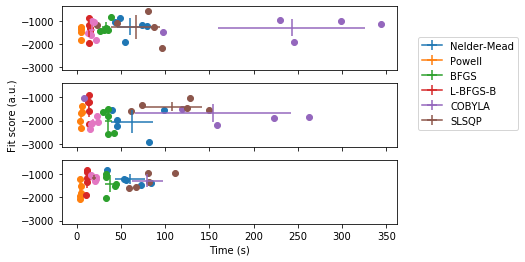

In [304]:
### Showing the time taken and the fit score for each method on a subset of the data
def plot_scores_and_times(gridsearch_out_dict, odour_index, ax=None):
    if ax is None:
        ax = plt.subplot(111)
    for index, i in enumerate(gridsearch_out_dict.keys()):
        try:
            ax.scatter(gridsearch_out_dict[i][odour_index][1], get_scores(gridsearch_out_dict, i)[odour_index], c=f'C{index}')

            ax.errorbar(np.mean(gridsearch_out_dict[i][odour_index][1], axis=0), np.mean(get_scores(gridsearch_out_dict, i)[odour_index], axis=0), xerr=np.std(gridsearch_out_dict[i][odour_index][1], axis=0), yerr=np.std(get_scores(gridsearch_out_dict, i)[odour_index], axis=0), label=i)
        except:
            pass
    # ax.legend()
    # ax.xlabel("Time (s)")
    # ax.ylabel('Fit error (a.u.)')
#plot_scores_and_times(gridsearch_out_dict, 0)
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)
[plot_scores_and_times(gridsearch_out_dict, k, ax=ax[k]) for k in range(3)]
ax[-1].legend(loc='upper left', bbox_to_anchor=(1.05, 3))
ax[1].set_ylabel('Fit score (a.u.)')
ax[-1].set_xlabel("Time (s)")


In [167]:
jwms_done_fit = dasked.collect_results()

In [307]:
pickle.dump(jwms_done_fit[0], open("230405_joint_weighting_models1.pkl", "wb"))

### Loading the joint weighting in and visualising

In [15]:
jwms = pickle.load(open("230405_joint_weighting_models1.pkl", "rb"))

In [27]:
[i.fit() for i in conc_models1];
[i.fit() for i in onset_models1];
[i.fit() for i in diff_models1];

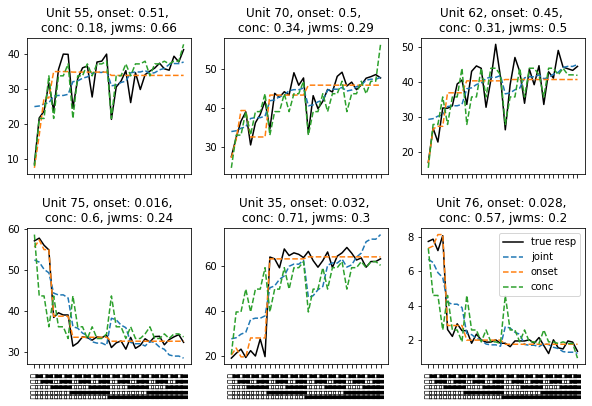

In [48]:
ui = 55
def plot_cell_responses(ui, ax=None):
    if ax is None:
        ax = plt.subplot(111)
    ax.plot(jwms.models[ui].true_resp, label="true resp", color='k')
    ax.plot(jwms.models[ui].pred_resp, label="joint", linestyle='--')
    ax.plot(onset_models1[ui].pred_resp, label="onset", linestyle='--')
    ax.plot(conc_models1[ui].pred_resp, label="conc", linestyle='--')

    ax.set_title(f"Unit {ui}, onset: {onset_models1[ui].fit_score:0.2}, \nconc: {conc_models1[ui].fit_score:0.2}, jwms: {jwms.models[ui].fit_score:0.2}")
    ax.set_xticks(range(32))
    ax.set_xticklabels(labels=glyphs, rotation=90)

# plt.plot(jwms.models[ui].true_resp, label="true resp", color='k')
# plt.plot(jwms.models[ui].pred_resp, label="joint", linestyle='--')
# plt.plot(onset_models1[ui].pred_resp, label="onset", linestyle='--')
# plt.plot(conc_models1[ui].pred_resp, label="conc", linestyle='--')
# #plt.plot(diff_models1[ui].pred_resp, label="diff", linestyle='--')
# plt.title(f"Unit {ui}, onset_score: {onset_models1[ui].fit_score:0.2}, conc_score: {conc_models1[ui].fit_score:0.2}, jwms_score: {jwms.models[ui].fit_score:0.2}, diff_score: {diff_models1[ui].fit_score:0.2}")
# plt.xticks(range(32), labels=glyphs, rotation=90)
# plt.legend()
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 3, hspace=0.4)
conc_axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])]
onset_axs = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2])]
[plot_cell_responses(i, ax=conc_axs[k]) for k, i in enumerate([55, 70, 62])]
[plot_cell_responses(i, ax=onset_axs[k]) for k, i in enumerate([75, 35, 76])]
[i.set_xticklabels([]) for i in conc_axs]
onset_axs[-1].legend()

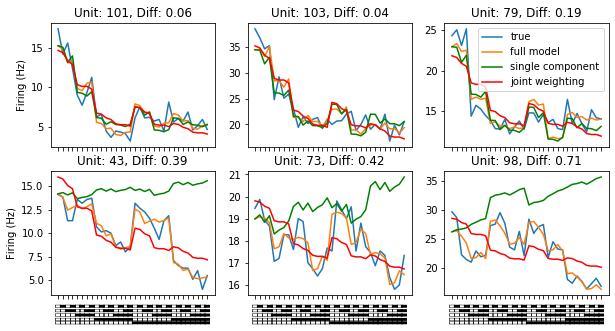

In [28]:
def plot_model_and_single_pred_jwms(ax, ui, base_model=diff_models1, single_weighting=False):
    ax.plot(base_model[ui].true_resp, label='true')
    ax.plot(base_model[ui].pred_resp, label='full model')
    if single_weighting:
        ax.plot(all_returned_models1[1][ui].pred_resp, label='single component', color='g')
    ax.plot(jwms.models[ui].pred_resp, label='joint weighting', color='r')

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 3)
axs_best = [fig.add_subplot(gs[0, i]) for i in range(3)]
axs_worst = [fig.add_subplot(gs[1, i]) for i in range(3)]
diff_diffs = abs(diff_errors1 - returned_scores1)
diff_jwms = np.array([i.fit_score for i in jwms.models])

top_diffs = np.argsort(diff_diffs)[:3]
bottom_diffs = np.argsort(diff_diffs)[-3:]

[plot_model_and_single_pred_jwms(i, j, single_weighting=True) for i, j in zip(axs_best, top_diffs)];
[plot_model_and_single_pred_jwms(i, j, single_weighting=True) for i, j in zip(axs_worst, bottom_diffs)];
axs_best[0].set_ylabel('Firing (Hz)')
axs_worst[0].set_ylabel('Firing (Hz)')
[i.set_xticks(range(32)) for i in axs_best];
[i.set_xticks(range(32)) for i in axs_worst];
[i.set_xticklabels(glyphs, rotation=90, fontsize=8) for i in axs_worst];
[i.set_xticklabels([]) for i in axs_best];
diff_diffs_jwms = abs(diff_errors1 - diff_jwms)
[i.set_title(f'Unit: {j}, Diff: {diff_diffs_jwms[j]:0.2f}') for i, j in zip(axs_best, top_diffs)];
[i.set_title(f'Unit: {j}, Diff: {diff_diffs_jwms[j]:0.2f}') for i, j in zip(axs_worst, bottom_diffs)];
axs_best[-1].legend()


98


Text(0, 0.5, 'Difference between full model\nand joint weighting')

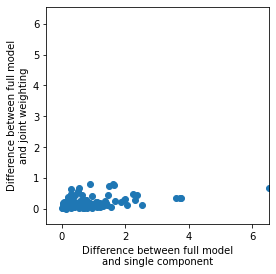

In [70]:
plt.figure(figsize=(4, 4))
plt.scatter(diff_diffs, diff_diffs_jwms)
max_lims = np.max([diff_diffs, diff_diffs_jwms])
plt.xlim(-0.5, max_lims)
plt.ylim(-0.5, max_lims)
print(np.argmax(diff_diffs))
plt.xlabel('Difference between full model\nand single component')
plt.ylabel('Difference between full model\nand joint weighting')


In [60]:
print(jwms.models[98].fit_score)
print(diff_models1[98].fit_score)

0.8495391100127645
0.1655552328727603


[Text(1, 0, 'Conc'),
 Text(2, 0, 'Joint'),
 Text(3, 0, 'Onset'),
 Text(4, 0, 'Single PC')]

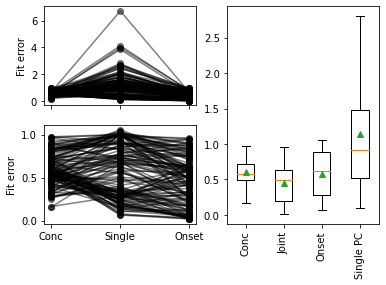

In [128]:
#plt.violinplot([[i.fit_score for i in jwms.models], [i.fit_score for i in conc_models1], [i.fit_score for i in diff_models1]], showmeans=True)
fig = plt.figure(figsize=(6, 4))
gs = GridSpec(2, 2)
ax = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[:, 1])]

ax[0].scatter([0 for i in range(130)], [i.fit_score for i in conc_models1], c='k', alpha=0.5)
ax[0].scatter([2 for i in range(130)], [i.fit_score for i in onset_models1], c='k', alpha=0.5)
ax[0].scatter([1 for i in range(130)], [i.fit_score for i in all_returned_models1[1]], c='k', alpha=0.5)
for i in range(130):
    ax[0].plot([0, 1, 2], [conc_models1[i].fit_score, all_returned_models1[1][i].fit_score, onset_models1[i].fit_score], c='k', alpha=0.5)

ax[1].scatter([0 for i in range(130)], [i.fit_score for i in conc_models1], c='k', alpha=0.5)
ax[1].scatter([2 for i in range(130)], [i.fit_score for i in onset_models1], c='k', alpha=0.5)
ax[1].scatter([1 for i in range(130)], [i.fit_score for i in jwms.models], c='k', alpha=0.5)
for i in range(130):
    ax[1].plot([0, 1, 2], [conc_models1[i].fit_score, jwms.models[i].fit_score, onset_models1[i].fit_score], c='k', alpha=0.5)
ax[2].boxplot([[i.fit_score for i in conc_models1], [i.fit_score for i in onset_models1], [i.fit_score for i in jwms.models], [i.fit_score for i in all_returned_models1[1]]], showmeans=True, showfliers=False)
ax[0].set_xticks([0, 1, 2])
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(['Conc', 'Single', 'Onset'])
ax[0].set_xticklabels([])
ax[0].set_ylabel("Fit error")
ax[1].set_ylabel("Fit error")
ax[2].set_xticklabels(['Conc', 'Joint', 'Onset', 'Single PC'], rotation=90)


In [129]:
print(np.corrcoef([[i.fit_score for i in conc_models1], [i.fit_score for i in onset_models1], [i.fit_score for i in jwms.models], [i.fit_score for i in all_returned_models1[1]]]))

[[1.         0.39209519 0.49094176 0.09199803]
 [0.39209519 1.         0.76396272 0.57236208]
 [0.49094176 0.76396272 1.         0.42597004]
 [0.09199803 0.57236208 0.42597004 1.        ]]


In [60]:
print(np.argsort([i.fit_score for i in conc_models1]))

[ 55  70  62 126 125 115 121  66 109 107 105 118  59 124 119  31  58 123
  54  29 113 122  64 127 114  26 117 112  83  60  90  68 101  50 100  41
 116  74 120  11  52  99  63  92  47 103  33  81  91  84  85  51  43  21
 129  30  18  48  44  76  40 108  88 102  56  23 106  10  71 104 128  34
  49  75  95  79   2  80  27  87  45  14  42  98  65  73  96  57  93   8
  77  61  35 110  94  53  37   5  32  36  39   4  72   3   7  16  86  46
   0  67  28  22  69  89   6  20  82   1 111  15  97  13  24  12   9  17
  78  38  25  19]


In [71]:
print(np.argsort([i.fit_score for i in conc_models1]))
print(np.argsort([i.fit_score for i in onset_models1]))


[ 55 126 121 125 115  62 109  70  59 118 105 107  66  31 123 124 122  54
  29  58 113 119 114  90  64  50 117 100  74  99  41  47 120 103  26  83
 101  91  81  63  92 112  51  60  33  85  76  40  68 127  56  88  11  18
  44  34  75  48  21  10  95  79  43 104  23  80  84  52 116  87  30  96
  49  27  42  45  98  93 102  35 128  37  61  39  73  36  72  77  94  14
  71  53   2 129 106  86   3 108 110  32   4 111  57   0  46  89  69  97
   1  82  67  16  20  65   8  19  38  78  15  22  28  13   6   9  12  17
  24  25   7   5]
[ 75  88  76  99  35  95  80  72  93  85  79  94  34 103  90  40  96 119
 126 117  48 115 105 101 100  74  87  10 121 104  29 114  45  86  47   3
  84  18  33 107 109  21 125 116  31 102  27  82 118  49  23  51  54  62
  42  56 113  92  41  83  11  39  70  55  91  81  26  37  66  32  36  44
  43  50  38  30 123   0 120 106 129  98 127  64 128 122  12 108  59  20
  14  13  46 124 112   8   2   9  73 110  77 111  89   5  58  15  52  69
  68  19  61  65   6  60  57  97 

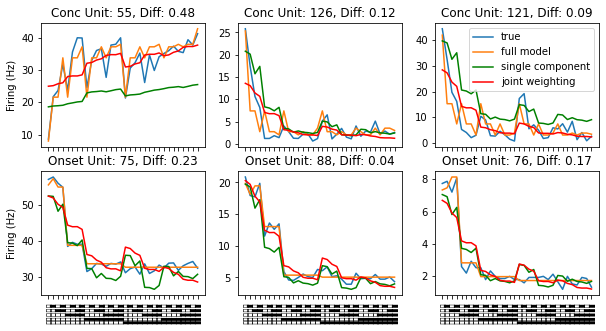

In [101]:
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 3)
axs_conc = [fig.add_subplot(gs[0, i]) for i in range(3)]
axs_onset = [fig.add_subplot(gs[1, i]) for i in range(3)]
diff_jwms = np.array([i.fit_score for i in jwms.models])
conc_errors = np.array([i.fit_score for i in conc_models1])
onset_errors = np.array([i.fit_score for i in onset_models1])

diff_diffs_conc = abs(conc_errors - diff_jwms)
diff_diffs_onset = abs(onset_errors - diff_jwms)

top_conc = np.argsort([i.fit_score for i in conc_models1])[:3]
top_onset = np.argsort([i.fit_score for i in onset_models1])[:3]

[plot_model_and_single_pred_jwms(i, j, base_model=conc_models1, single_weighting=True) for i, j in zip(axs_conc, top_conc)];
[plot_model_and_single_pred_jwms(i, j, base_model=onset_models1, single_weighting=True) for i, j in zip(axs_onset, top_onset)];
axs_conc[0].set_ylabel('Firing (Hz)')
axs_onset[0].set_ylabel('Firing (Hz)')
[i.set_xticks(range(32)) for i in axs_conc];
[i.set_xticks(range(32)) for i in axs_onset];
[i.set_xticklabels(glyphs, rotation=90, fontsize=8) for i in axs_onset];
[i.set_xticklabels([]) for i in axs_conc];
axs_conc[-1].legend()
[i.set_title(f'Conc Unit: {j}, Diff: {diff_diffs_conc[j]:0.2f}') for i, j in zip(axs_conc, top_conc)];
[i.set_title(f'Onset Unit: {j}, Diff: {diff_diffs_onset[j]:0.2f}') for i, j in zip(axs_onset, top_onset)];


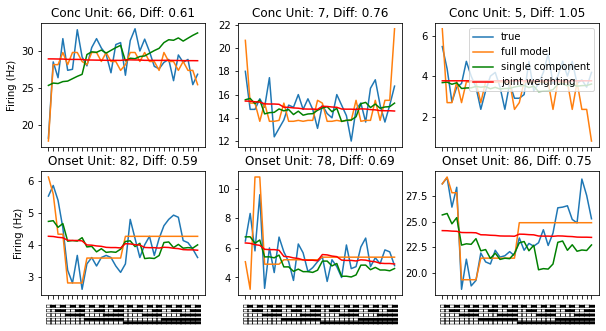

In [103]:
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 3)
axs_conc = [fig.add_subplot(gs[0, i]) for i in range(3)]
axs_onset = [fig.add_subplot(gs[1, i]) for i in range(3)]
diff_jwms = np.array([i.fit_score for i in jwms.models])
conc_errors = np.array([i.fit_score for i in conc_models1])
onset_errors = np.array([i.fit_score for i in onset_models1])

diff_diffs_conc = abs(conc_errors - diff_jwms)
diff_diffs_onset = abs(onset_errors - diff_jwms)

top_conc = np.argsort(diff_diffs_conc)[-3:]
top_onset = np.argsort(diff_diffs_onset)[-3:]

[plot_model_and_single_pred_jwms(i, j, base_model=conc_models1, single_weighting=True) for i, j in zip(axs_conc, top_conc)];
[plot_model_and_single_pred_jwms(i, j, base_model=onset_models1, single_weighting=True) for i, j in zip(axs_onset, top_onset)];
axs_conc[0].set_ylabel('Firing (Hz)')
axs_onset[0].set_ylabel('Firing (Hz)')
[i.set_xticks(range(32)) for i in axs_conc];
[i.set_xticks(range(32)) for i in axs_onset];
[i.set_xticklabels(glyphs, rotation=90, fontsize=8) for i in axs_onset];
[i.set_xticklabels([]) for i in axs_conc];
axs_conc[-1].legend()
[i.set_title(f'Conc Unit: {j}, Diff: {diff_diffs_conc[j]:0.2f}') for i, j in zip(axs_conc, top_conc)];
[i.set_title(f'Onset Unit: {j}, Diff: {diff_diffs_onset[j]:0.2f}') for i, j in zip(axs_onset, top_onset)];


## Use the single weightings to generate modelled firing rates

In [59]:
[i.fit(W=j) for i, j in zip(jwms_fit.models, jwms_fit.model_weights)];
[i.fit(W=j) for i, j in zip(jwms_fit_no_mean.models, jwms_fit_no_mean.model_weights)];

In [60]:
all_futures = []
for jwm in [jwms_fit, jwms_fit_no_mean]:
    for i in range(20):
        generate_and_dask(jwm.models, method='add', noise_level=i)
        all_futures.append(dasked.current_futures)

all_futures = np.concatenate(all_futures)
all_futures = list(all_futures)
dasked.current_futures = all_futures

In [65]:
dasked.check_progress()

finished 4000


In [88]:
res = dasked.collect_results()
res = np.array(res).reshape(2, 20, 100, 2, 32)
preds1 = res[0, :, :, 0]
trues1 = res[0, :, :, 1]
cms_jwm1 = [confusion_matrix(trues1[i].flatten(), preds1[i].flatten(), labels=range(32), normalize='true') for i in range(20)]
preds_no_mean1 = res[1, :, :, 0]
trues_no_mean1 = res[1, :, :, 1]
cms_no_mean1 = [confusion_matrix(trues_no_mean1[i].flatten(), preds_no_mean1[i].flatten(), labels=range(32), normalize='true') for i in range(20)]

6
10
0.7258335061360932
3.2174000000000005


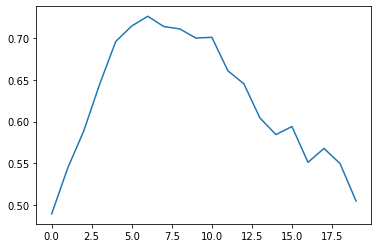

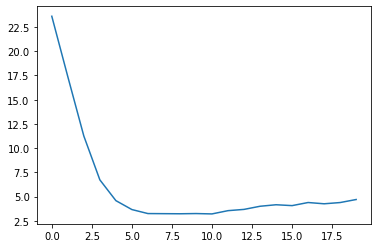

In [89]:
cm_choice = cms_jwm1
plt.plot([np.corrcoef(cm_choice[i].flatten(), cm_true1.flatten())[0, 1] for i in range(20)])
print(np.argmax([np.corrcoef(cm_choice[i].flatten(), cm_true1.flatten())[0, 1] for i in range(20)]))
plt.figure()
plt.plot([np.sum((i - cm_true1)**2) for i in cm_choice])
print(np.argmin([np.sum((i - cm_true1)**2) for i in cm_choice]))
print(np.max([np.corrcoef(cm_choice[i].flatten(), cm_true1.flatten())[0, 1] for i in range(20)]))
print(np.min([np.sum((i - cm_true1)**2) for i in cm_choice]))

In [96]:
print(cms1.shape)

(20, 32, 32)


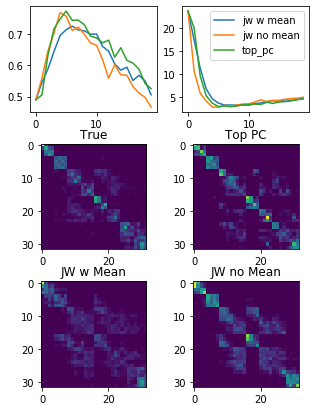

In [104]:
fig = plt.figure(figsize=(5, 7))
gs = GridSpec(3, 2, hspace=0.3)
plot_axs = [fig.add_subplot(gs[0, i]) for i in range(2)]
im_axs = [fig.add_subplot(gs[1+int(i/2), i%2]) for i in range(4)]
# sub_gs = gs[1, :].subgridspec(1, 3)
# im_axs = [fig.add_subplot(sub_gs[i]) for i in range(3)]
labels=['jw w mean', 'jw no mean', 'top_pc']
for index, cm_choice in enumerate([cms_jwm1, cms_no_mean1]):
    plot_axs[0].plot([np.corrcoef(cm_choice[i].flatten(), cm_true1.flatten())[0, 1] for i in range(20)])
    plot_axs[1].plot([np.sum((i - cm_true1)**2) for i in cm_choice], label=labels[index])
    im_axs[index+2].imshow(cm_choice[np.argmin([np.sum((i - cm_true1)**2) for i in cm_choice])])
plot_axs[0].plot([np.corrcoef(cms1[1, i].flatten(), cm_true1.flatten())[0, 1] for i in range(20)])
plot_axs[1].plot([np.sum((i - cm_true1)**2) for i in cms1[1]], label=labels[-1])
im_axs[0].imshow(cm_true1)
im_axs[1].imshow(cms1[1, 5])
im_titles = ['True', 'Top PC', 'JW w Mean', 'JW no Mean']
[ax.set_title(i) for ax, i in zip(im_axs, im_titles)]
plot_axs[1].legend()

In [105]:
print(np.corrcoef(cms_no_mean1[5].flatten(), cm_true1.flatten())[0, 1])

0.7575833267948494


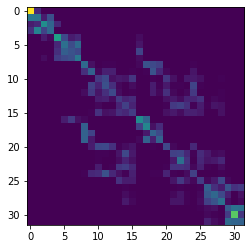

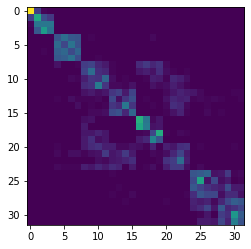

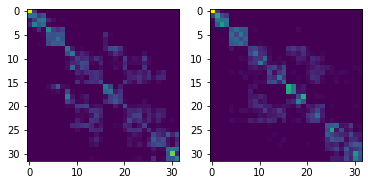

In [142]:
plt.imshow(cms1[5])
plt.figure()
plt.imshow(cm_true1)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cms1[6])
ax[1].imshow(cm_true1)

## Measuring the goodness of fit of different models

In [98]:
mean_usrt1 = [[i.mean(axis=-1) for i in j] for j in unit_usrt1]


def remove_0_rows(ct):
    ct = ct[ct.sum(axis=1) != 0]
    ct = ct[:, ct.sum(axis=0) != 0]
    return ct
def check_chi_fit(fit_type, repeats=5000):
    chis = []
    fit_preds = []
    all_fit_params = []
    for ui in tqdm(good_indexes, position=0, leave=False):
        for ti in range(32):
            fit_params = fit_type.fit(mean_usrt1[ui][ti]/2)
            fit_pred = fit_type(*fit_params).rvs(repeats).astype(int)
            fit_preds.append(fit_pred)
            fit_pred = fit_pred[fit_pred >= 0]
            all_fit_params.append(fit_params)
            #ct = np.array([bs_mean_usrt[ui][ti]/2, fit_pred])
            
            mins = np.min([np.min(fit_pred), np.min(mean_usrt1[ui][ti]/2)])
            maxs = np.max([np.max(fit_pred), np.max(mean_usrt1[ui][ti]/2)])
            bins = np.arange(mins, maxs+1)
            true_hist = np.histogram(mean_usrt1[ui][ti]/2, bins=bins)[0]
            pred_hist = np.histogram(fit_pred, bins=bins)[0]
            ct = np.array([true_hist, pred_hist])
            ct = remove_0_rows(ct)
            try:
                chis.append(chi2_contingency(ct, lambda_='log-likelihood')[1])
            except:
                print(ct)
                print(np.array([true_hist, pred_hist]))
                print(ui, ti)
                for i in ct.T:
                    print(i)
                sys.exit()
    chis = np.array(chis).reshape(130, 32)
    fit_params = np.array(all_fit_params).reshape(130, 32, len(fit_params))
    fit_preds = np.array(fit_preds).reshape(130, 32, repeats)
    return chis, fit_preds, fit_params
chis_sn, fit_preds_sn, fit_params_sn = check_chi_fit(skewnorm, repeats=5000)

In [120]:
### Special chi fit for Poisson
mean_usrt1 = [[i.mean(axis=-1) for i in j] for j in unit_usrt1]
chis = []
fit_preds_p = []
for ui in tqdm(good_indexes, position=0, leave=False):
    poisson_pred = [poisson(i.mean()/2).rvs(5000) for i in mean_usrt1[ui]]
    for ti in range(32):
        mins = np.min([np.min(poisson_pred[ti]), np.min(mean_usrt1[ui][ti]/2)])
        maxs = np.max([np.max(poisson_pred[ti]), np.max(mean_usrt1[ui][ti]/2)])
        bins = np.arange(mins, maxs+1)
        true_hist = np.histogram(mean_usrt1[ui][ti]/2, bins=bins)[0]
        pred_hist = np.histogram(poisson_pred[ti], bins=bins)[0]
        ct = np.array([true_hist, pred_hist])
        fit_preds_p.append(poisson_pred[ti])
        ct = remove_0_rows(ct)
        chis.append(chi2_contingency(ct, lambda_='log-likelihood')[1])
chis = np.array(chis).reshape(130, 32)
fit_preds_p = np.array(fit_preds_p).reshape(130, 32, 5000)

In [90]:
mean_usrt1 = [[i.mean(axis=-1) for i in j] for j in unit_usrt1]

def get_poisson_fit(mean_firing):
    all_p_preds = []
    for ui in tqdm(range(len(mean_firing)), position=0, leave=False):
        poisson_pred = [poisson(i.mean()/2).rvs(5000) for i in mean_firing[ui]]
        all_p_preds.append(poisson_pred)
    return np.array(all_p_preds)

def get_skewnorm_fit(skewnorm_params, predicted_mean_firing):
    all_pred_firing = []
    for i in range(len(skewnorm_params)):
        changed_params = skewnorm_params[i]
        changed_params[:, 0] = predicted_mean_firing[i]/2
        pred_firing = np.array([skewnorm(*j).rvs(5000).astype(int) for j in changed_params])
        pred_firing = pred_firing*2
        all_pred_firing.append(pred_firing)
    all_pred_firing = np.array(all_pred_firing)
    return all_pred_firing
#pc1_sn_pred_firing = get_skewnorm_fit(fit_params_sn, pc1_firing)

#poisson_preds = get_poisson_fit(np.array(mean_usrt1)[good_indexes])


In [80]:
#[i.fit() for i in all_returned_models1[1]]
pc1_firing = np.array([i.pred_resp for i in all_returned_models1[1]])
print(pc1_firing.shape)

(130, 32)


In [91]:
pc1_preds = get_poisson_fit(pc1_firing)

In [101]:
pc1_preds_sn = get_skewnorm_fit(fit_params_sn, pc1_firing)

In [99]:
print(np.histogram(mean_usrt1[117][1]/2, bins=np.arange(0, 2)))
print(mean_usrt1[117][1])

(array([30]), array([0, 1]))
[0. 0. 0. 2. 0. 0. 0. 0. 2. 0. 2. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [93]:

def classify_modelled_data(fit_choice, model_repeat_selection=slice(0, 5), classifier_repeats=100):
    repeat_length = len(range(5000)[model_repeat_selection])
    ys = [i for i in range(32) for j in range(repeat_length)]
    preds = []
    trues = []
    for k in trange(classifier_repeats, position=0, leave=False):
        X_train, X_test, y_train, y_test = train_test_split(fit_choice[:, :, model_repeat_selection].reshape(130, -1).T, ys, test_size=32)
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        preds.append(pred)
        trues.append(y_test)
    return preds, trues
# all_preds_sn = []
# all_trues_sn = []
# for i in trange(100, position=0, leave=False):
#     preds_sn, trues_sn = classify_modelled_data(fit_preds_sn, model_repeat_selection=slice(0+5*i, (i+1)*5), classifier_repeats=100)
#     all_preds_sn.append(preds_sn)
#     all_trues_sn.append(trues_sn)
# all_preds_p = []
# all_trues_p = []
# for i in range(2, 11):
#     preds_sn, trues_sn = classify_modelled_data(fit_preds_sn, modelled_repeats=i, classifier_repeats=100)
#     preds_p, trues_p = classify_modelled_data(fit_preds_p, modelled_repeats=i, classifier_repeats=100)
#     print(i)
#     all_preds_sn.append(preds_sn)
#     all_trues_sn.append(trues_sn)
#     all_preds_p.append(preds_p)
#     all_trues_p.append(trues_p)
#p_classified = [classify_modelled_data(np.array(poisson_preds), model_repeat_selection=slice(0+5*i, (i+1)*5), classifier_repeats=100) for i in range(10)]


In [94]:
pc1_classified = [classify_modelled_data(np.array(pc1_preds), model_repeat_selection=slice(0+5*i, (i+1)*5), classifier_repeats=100) for i in range(10)]

In [102]:
pc1_classified_sn = [classify_modelled_data(np.array(pc1_preds_sn), model_repeat_selection=slice(0+5*i, (i+1)*5), classifier_repeats=100) for i in range(10)]

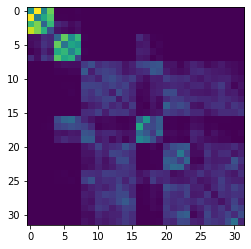

In [95]:
pc1_classified = np.array(pc1_classified)
preds_p = pc1_classified[:, 0].flatten()
trues_p = pc1_classified[:, 1].flatten()
cm = confusion_matrix(trues_p, preds_p, normalize='true', labels=range(32))
plt.imshow(cm)

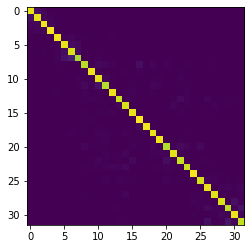

In [103]:
pc1_classified_sn = np.array(pc1_classified_sn)
preds_sn = pc1_classified_sn[:, 0].flatten()
trues_sn = pc1_classified_sn[:, 1].flatten()
cm = confusion_matrix(trues_sn, preds_sn, normalize='true', labels=range(32))
plt.imshow(cm)

In [57]:
print(np.corrcoef(cm.flatten(), cm_true1.flatten()))
print(np.sum((cm_true1 - cm)**2))

[[1.         0.81904502]
 [0.81904502 1.        ]]
2.071501209672445


In [109]:
fit_preds_sn_scattered = dasked.client.scatter(fit_preds_sn)

In [121]:
fit_preds_p_scattered = dasked.client.scatter(fit_preds_p)

In [150]:
dask_outs = []
for scatter_type in [fit_preds_sn_scattered, fit_preds_p_scattered]:
    for model_repeat_length in range(2, 11):
        for i in range(100):
            dask_outs.append(dask.delayed(classify_modelled_data)(scatter_type, model_repeat_selection=slice(0+model_repeat_length*i, (i+1)*model_repeat_length), classifier_repeats=100))

dask_outs = dasked.client.compute(dask_outs)
dasked.current_futures = dask_outs

In [159]:
dasked.check_progress()

finished 1800


In [122]:
dask_outs = [dask.delayed(classify_modelled_data)(fit_preds_p_scattered, model_repeat_selection=slice(0+5*i, (i+1)*5), classifier_repeats=100) for i in range(100)]
dask_outs = dasked.client.compute(dask_outs)
dasked.current_futures = dask_outs

In [132]:
dasked.check_progress()

finished 100


In [161]:
res = dasked.collect_results()

3 3


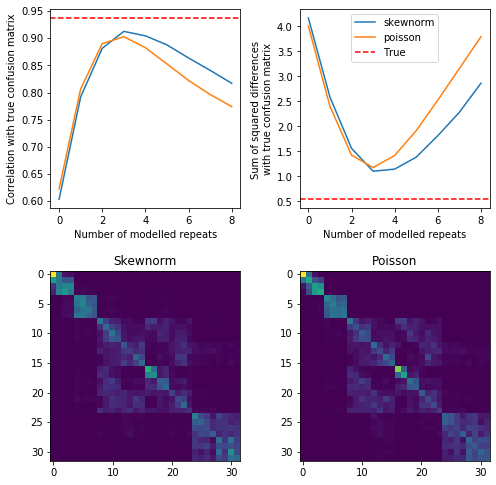

In [181]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax = ax.flatten()
res = np.array(res).reshape(2, 9, 100, 2, 100, 32)
preds_sn = res[0, :, :, 0].reshape(9, -1)
trues_sn = res[0, :, :, 1].reshape(9, -1)
preds_p = res[1, :, :, 0].reshape(9, -1)
trues_p = res[1, :, :, 1].reshape(9, -1)
cms_sn = [confusion_matrix(trues_sn[i], preds_sn[i], labels=range(32), normalize='true') for i in range(9)]
cms_p = [confusion_matrix(trues_p[i], preds_p[i], labels=range(32), normalize='true') for i in range(9)]
corrs_sn = [np.corrcoef(cms_sn[i].flatten(), cm_true1.flatten())[0, 1] for i in range(9)]
corrs_p = [np.corrcoef(cms_p[i].flatten(), cm_true1.flatten())[0, 1] for i in range(9)]
ax[0].plot(corrs_sn)
ax[0].plot(corrs_p)
ax[0].axhline(np.corrcoef(cm1_rs.flatten(), cm2_rs.flatten())[0, 1], linestyle='--', color='r')
ax[0].set_xlabel('Number of modelled repeats')
ax[0].set_ylabel('Correlation with true confusion matrix')
ax[1].set_xlabel('Number of modelled repeats')
ax[1].set_ylabel('Sum of squared differences \nwith true confusion matrix')
print(np.argmax(corrs_sn), np.argmax(corrs_p))

ax[2].imshow(cms_sn[3])

ax[3].imshow(cms_p[3])

diffs_sn = [np.sum((cms_sn[i] - cm_true1)**2) for i in range(9)]
diffs_p = [np.sum((cms_p[i] - cm_true1)**2) for i in range(9)]
ax[1].plot(diffs_sn, label='skewnorm')
ax[1].plot(diffs_p, label='poisson')
ax[1].axhline(np.sum((cm1_rs - cm2_rs)**2), linestyle='--', color='r', label='True')
ax[1].legend()
ax[2].set_title('Skewnorm')
ax[3].set_title('Poisson')
plt.tight_layout()
#cm_sn = confusion_matrix(trues_sn, preds_sn, labels=range(32), normalize='true')
#plt.imshow(cm_sn)

In [ ]:
cms_sn = [confusion_matrix(trues_sn[i], preds_sn[i], labels=range(32), normalize='true') for i in range(9)]

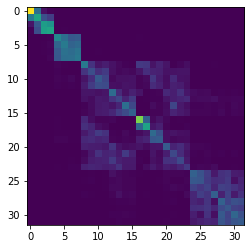

In [134]:
res = np.array(res).reshape(100, 2, 100, 32)
preds_p = res[:, 0].flatten()
trues_p = res[:, 1].flatten()
cm_p = confusion_matrix(trues_p, preds_p, labels=range(32), normalize='true')
plt.imshow(cm_p)

### Comparing the fit to the difference between true confusion matrices

In [126]:
def split_usrt(usrt, split_size=0.5, seed=100):
    usrt_split1 = []
    usrt_split2 = []
    np.random.seed(seed)
    for unit in usrt:
        unit_split1 = []
        unit_split2 = []
        for stimuli in unit:
            repeat_size = len(stimuli)
            split_indexes1 = np.random.choice(repeat_size, int(repeat_size*split_size), replace=False)
            split_indexes2 = np.array([i for i in range(repeat_size) if i not in split_indexes1])
            unit_split1.append(stimuli[split_indexes1])
            unit_split2.append(stimuli[split_indexes2])
        usrt_split1.append(unit_split1)
        usrt_split2.append(unit_split2)

    usrt_split1 = np.array(usrt_split1)
    usrt_split2 = np.array(usrt_split2)
    return usrt_split1, usrt_split2

def dask_split_usrt_and_classify(usrt_scattered, split_seed=None, classifier_seed=None):
    usrt_split1, usrt_split2 = split_usrt(usrt_scattered, seed=split_seed)
    np.random.seed(classifier_seed)
    score1, pred1 = split_and_classify(usrt_split1, range(32), classifier=RandomForestClassifier)
    score2, pred2 = split_and_classify(usrt_split2, range(32), classifier=RandomForestClassifier)
    return pred1, pred2



In [129]:
dask_outs = [dask.delayed(dask_split_usrt_and_classify)(usrt_scattered1, None, None) for i in range(100)]
dask_outs = dasked.client.compute(dask_outs)
dasked.current_futures = dask_outs

In [133]:
res = dasked.collect_results()
res = np.array(res).reshape(100, 2, 32)
pred1 = res[:, 0].flatten()
pred2 = res[:, 1].flatten()
trues = np.array([i for j in range(100) for i in range(32)])
cm1_ss = confusion_matrix(trues, pred1, labels=range(32), normalize='true')
cm2_ss = confusion_matrix(trues, pred2, labels=range(32), normalize='true')

In [134]:
res = dasked.collect_results()
res = np.array(res).reshape(100, 2, 32)
pred1 = res[:, 0].flatten()
pred2 = res[:, 1].flatten()
trues = np.array([i for j in range(100) for i in range(32)])
cm1_rs = confusion_matrix(trues, pred1, labels=range(32), normalize='true')
cm2_rs = confusion_matrix(trues, pred2, labels=range(32), normalize='true')

In [ ]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(cm1_ss)
ax[1, 0].imshow(cm2_ss)
ax[0, 1].imshow(cm1_rs)
ax[1, 1].imshow(cm2_rs)
ax[0, 0].set_title(f'Same seed:, corr:{np.corrcoef(cm1_ss.flatten(), cm2_ss.flatten())[0, 1]:.2f},\nerror:{np.sum((cm1_ss - cm2_ss)**2):.2f}')
ax[0, 1].set_title(f'Different seed, corr:{np.corrcoef(cm1_rs.flatten(), cm2_rs.flatten())[0, 1]:.2f},\nerror:{np.sum((cm1_rs - cm2_rs)**2):.2f}')

In [140]:
print(np.corrcoef([cm_sn.flatten(), cm_p.flatten(), cm_true1.flatten()]))
print(np.corrcoef([cm1_rs.flatten(), cm2_rs.flatten()]))

[[1.         0.96500438 0.91122019]
 [0.96500438 1.         0.90253751]
 [0.91122019 0.90253751 1.        ]]
[[1.         0.93715821]
 [0.93715821 1.        ]]


In [144]:
print(np.sum((cm_sn - cm_true1)**2))
print(np.sum((cm_p - cm_true1)**2))
print(np.sum((cm1_rs - cm2_rs)**2))

1.114525357554554
1.1803509625017532
0.5429999999999999


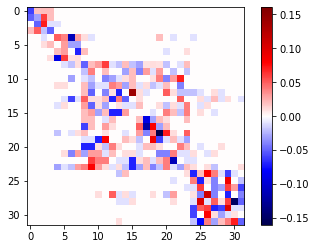

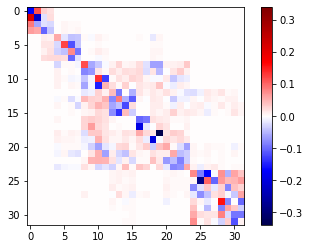

In [149]:
plt.imshow(cm1_rs - cm2_rs, vmax=abs(cm1_rs - cm2_rs).max(), vmin=-abs(cm1_rs - cm2_rs).max(), cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(cm_sn - cm_true1, vmax=abs(cm_sn - cm_true1).max(), vmin=-abs(cm_sn - cm_true1).max(), cmap='seismic')
plt.colorbar()

In [191]:
cms_sn = [confusion_matrix(i.flatten(), j.flatten(), normalize='true', labels=range(32)) for i, j in zip(np.array(all_trues_sn), np.array(all_preds_sn))];
cms_p = [confusion_matrix(i.flatten(), j.flatten(), normalize='true', labels=range(32)) for i, j in zip(np.array(all_trues_p), np.array(all_preds_p))];

5
5
4
4


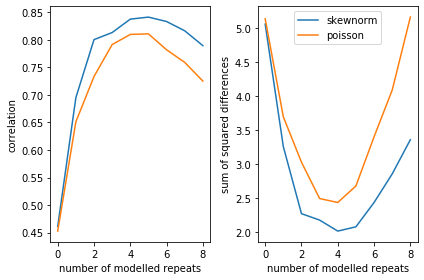

In [227]:
corrs_sn = [np.corrcoef(i.flatten(), cm_true1.flatten())[0, 1] for i in np.array(cms_sn)];
corrs_p = [np.corrcoef(i.flatten(), cm_true1.flatten())[0, 1] for i in np.array(cms_p)];
sum_diff_sn = [np.sum((i.flatten() - cm_true1.flatten())**2) for i in np.array(cms_sn)];
sum_diff_p = [np.sum((i.flatten() - cm_true1.flatten())**2) for i in np.array(cms_p)];
fig, ax = plt.subplots(1, 2)
ax[0].plot(corrs_sn)
ax[0].plot(corrs_p)
print(np.argmax(corrs_sn))
print(np.argmax(corrs_p))

ax[1].plot(sum_diff_sn)
ax[1].plot(sum_diff_p)
print(np.argmin(sum_diff_sn))
print(np.argmin(sum_diff_p))
ax[1].legend(['skewnorm', 'poisson'])
ax[0].set_ylabel('correlation')
ax[1].set_ylabel('sum of squared differences')
ax[0].set_xlabel('number of modelled repeats')
ax[1].set_xlabel('number of modelled repeats')
plt.tight_layout()


Text(0.5, 1.0, 'Poisson')

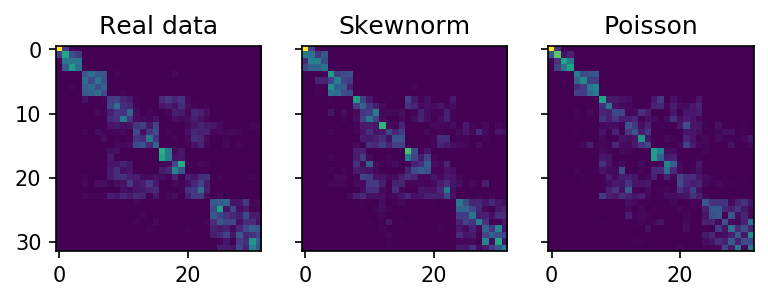

In [228]:
fig, ax = plt.subplots(1, 3, sharey=True, dpi=150)
ax[0].imshow(cm_true1)
ax[1].imshow(cms_sn[4])
ax[2].imshow(cms_p[4])
ax[0].set_title('Real data')
ax[1].set_title('Skewnorm')
ax[2].set_title('Poisson')

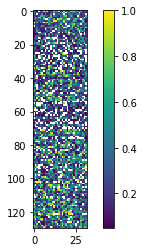

In [151]:
chis_masked = np.ma.masked_where(chis < 0.05, chis)
chis_sn_masked = np.ma.masked_where(chis_sn < 0.05, chis_sn)
plt.imshow(chis_sn_masked)
plt.colorbar()

Text(0, 0.5, 'Unit')

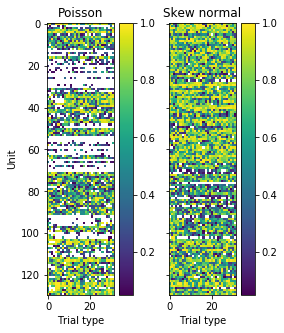

In [149]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(4, 5))
im = ax[0].imshow(chis_masked, vmax=1)
ax[1].imshow(chis_sn_masked, vmax=1)
plt.colorbar(im, ax=ax[0])
plt.colorbar(im, ax=ax[1])
ax[0].set_title('Poisson')
ax[1].set_title('Skew normal')
ax[0].set_xlabel('Trial type')
ax[1].set_xlabel('Trial type')
ax[0].set_ylabel('Unit')

## Determining if including Gaussian noise as well as the Poisson will generate a higher correlation confusion matrix

In [4]:
mean_usrt1 = np.array([[i.mean() for i in j] for j in unit_usrt1])
p_fits = np.array([[poisson(i).rvs(5000) for i in j] for j in mean_usrt1[good_indexes]])


In [6]:
jwms = pickle.Unpickler(open('230405_joint_weighting_models1.pkl', 'rb')).load()
#[i.fit() for i in jwms.models]
jwms_preds = np.array([i.pred_resp for i in jwms.models])
diff_preds = np.array([i.pred_resp for i in diff_models1])
print(jwms_preds.shape)

(130, 32)


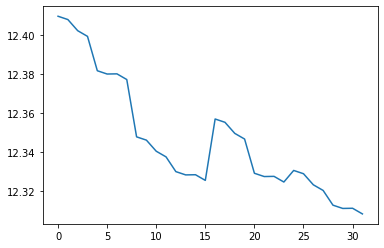

In [168]:
#plt.plot(jwms.models[0].pred_resp)
plt.plot(jwms.models[1].pred_resp)

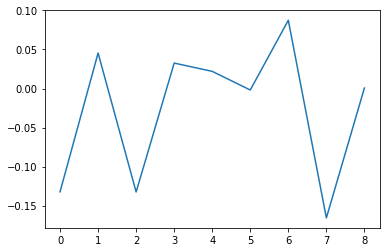

In [157]:
plt.plot(jwms.models[0].opt_out.x[:-1])

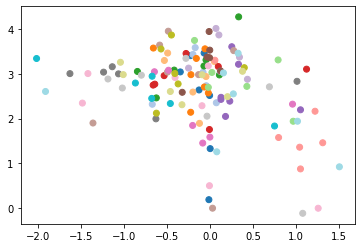

In [154]:
plt.scatter(jwms.opt_out.x[8:138], jwms.opt_out.x[138:268], c=range(130), cmap='tab20')

In [8]:
def generate_poisson_data(base_data, number_of_reps=5):
    poisson_generated = np.array([[poisson(i).rvs(number_of_reps) for i in j] for j in base_data])
    return poisson_generated

#all_ps_generated = [generate_poisson_data(jwms_preds, number_of_reps=i) for i in range(2, 15)]
#p_generated = generate_poisson_data(jwms_preds, number_of_reps=5)
#print(p_generated.shape)

In [31]:
all_ys = [[i for i in range(32) for j in range(k)] for k in range(2, 15)]


In [171]:
all_ps_scattered = [dasked.client.scatter(j.reshape(130, -1).T) for i, j in enumerate(all_ps_generated)]
all_ys_scattered = [dasked.client.scatter(j) for i, j in enumerate(all_ys)]

In [48]:
print(all_ps_scattered[0])

<Future: finished, type: numpy.ndarray, key: ndarray-dac8b012664b73ec9a05aae9c6b189e3>


In [9]:
def dask_and_generate_poisson(base_data, number_of_reps=5):
    poisson_generated = generate_poisson_data(base_data, number_of_reps=number_of_reps)
    ys = [i for i in range(32) for j in range(number_of_reps)]
    poisson_generated = poisson_generated.reshape(130, -1).T
    preds, trues = dask_svm(poisson_generated, ys, 32)
    return preds, trues

In [197]:
dask_futures = []
for j in range(2, 30):
    for i in range(1000):
        dask_futures.append(dask.delayed(dask_and_generate_poisson)(jwms_preds, j))
dask_outs = dasked.client.compute(dask_futures)
dasked.current_futures = dask_outs


In [254]:
dask_100 = [dask.delayed(dask_and_generate_poisson)(jwms_preds, 100) for i in range(1000)]
dask_100 = dasked.client.compute(dask_100)
dasked.current_futures = dask_100

In [260]:
dasked.check_progress()

finished 1000


In [262]:
dask_100 = dasked.collect_results()
dask_100 = np.array(dask_100).reshape(1000, 2, 32)

0.8209492625456454


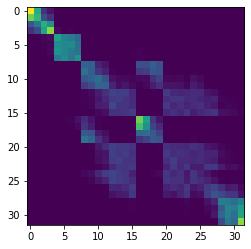

In [264]:
cm = confusion_matrix(dask_100[:, 1, :].flatten(), dask_100[:, 0, :].flatten(), normalize='true', labels=range(32))
plt.imshow(cm)
print(dp(cm, cm_true1))

In [246]:
dask_outs = dasked.collect_results()

In [250]:
dask_outs = np.array(dask_outs).reshape(28, 1000, 2, 32)

2.366424


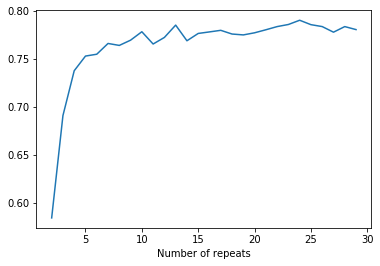

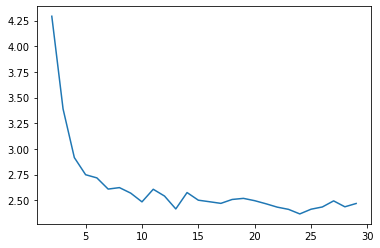

In [252]:
cms = [confusion_matrix(i[:, 1].flatten(), i[:, 0].flatten(), normalize='true', labels=range(32)) for i in dask_outs];
corrs = [np.corrcoef(i.flatten(), cm_true1.flatten())[0, 1] for i in np.array(cms)];
diffs = [np.sum((i.flatten() - cm_true1.flatten())**2) for i in np.array(cms)];
plt.plot(np.arange(2, 30), corrs)
plt.xlabel('Number of repeats')
plt.figure()
plt.plot(np.arange(2, 30), diffs)
print(np.min(diffs))

In [13]:
y = np.array([i for i in range(32) for j in range(5)])
preds = []
trues = []
for i in trange(100,position=0, leave=True):
    p_generated = generate_poisson_data(jwms_preds, number_of_reps=5)
    X_train, X_test, y_train, y_test = train_test_split(p_generated.reshape(130, -1).T, y, test_size=32)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    preds.append(clf.predict(X_test))
    trues.append(y_test)

100%|██████████| 100/100 [03:56<00:00,  2.37s/it]


Text(0.5, 1.0, 'Real data')

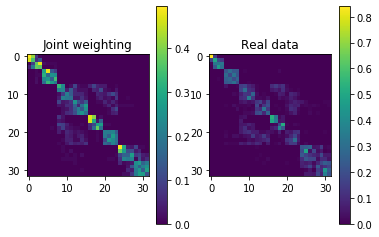

In [64]:
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten(), normalize='true', labels=range(32))
fig, ax = plt.subplots(1, 2)
im = ax[0].imshow(cm)
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(cm_true1)
plt.colorbar(im, ax=ax[1])
ax[0].set_title('Joint weighting')
ax[1].set_title('Real data')


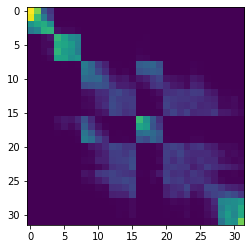

In [196]:
plt.imshow(cms[-1])

In [113]:
rm_diagonal = [i - np.diag(np.diag(i)) for i in cms]
cm_true_rm_diagonal = cm_true1 - np.diag(np.diag(cm_true1))

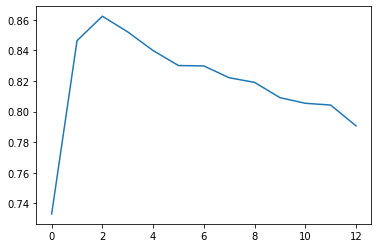

In [115]:
corrs = [np.corrcoef(i.flatten(), cm_true_rm_diagonal.flatten())[0, 1] for i in np.array(rm_diagonal)];
plt.plot(corrs)

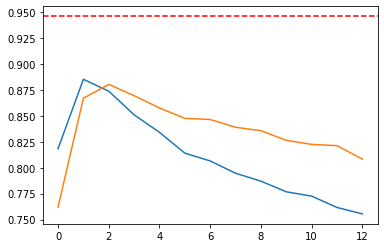

In [147]:
def dp(cm1, cm2):
    return np.dot(cm1.flatten(), cm2.flatten())/(np.linalg.norm(cm1.flatten())*np.linalg.norm(cm2.flatten()))
dps = [dp(cm, cm_true1) for cm in cms]
dps_rm = [dp(cm, cm_true_rm_diagonal) for cm in rm_diagonal]
plt.plot(dps)
plt.plot(dps_rm)
plt.axhline(dp(cm1_rs, cm2_rs), color='r', linestyle='--')

In [148]:
print(dp(cm1_rs, cm2_rs))
print(np.corrcoef(cm1_rs.flatten(), cm2_rs.flatten())[0, 1])
print()

0.946072552760856
0.9338974698271936


In [137]:
print(np.corrcoef(cm1_rs.flatten(), cm2_rs.flatten())[0, 1])

0.9338974698271936


In [138]:
np.dot(cm1_rs.flatten(), cm2_rs.flatten())/(np.linalg.norm(cm1_rs.flatten())*np.linalg.norm(cm2_rs.flatten()))

0.946072552760856

In [140]:
def dp(cm1, cm2):
    return np.dot(cm1.flatten(), cm2.flatten())/(np.linalg.norm(cm1.flatten())*np.linalg.norm(cm2.flatten()))

In [141]:
dp(cm_true1, cm_true2)

0.7957180556542525

# Trying to sumarise it all up

So - I can generate a reasonably good confusion matrix - with a relatively high correlation using the Poisson process and limiting the number of repeats I use. However, for a single weighting I have the same probem as before. I tried both the single weighting setting the PCs to 0 and a single weighting shared across all the different trial types.

### Generating all the confusion matrices and modelled spikes

In [7]:
## Starting off with a good estimator for the difference between two confusion matrices
def split_usrt(usrt, split_size=0.5, seed=100):
    usrt_split1 = []
    usrt_split2 = []
    np.random.seed(seed)
    for unit in usrt:
        unit_split1 = []
        unit_split2 = []
        for stimuli in unit:
            repeat_size = len(stimuli)
            split_indexes1 = np.random.choice(repeat_size, int(repeat_size*split_size), replace=False)
            split_indexes2 = np.array([i for i in range(repeat_size) if i not in split_indexes1])
            unit_split1.append(stimuli[split_indexes1])
            unit_split2.append(stimuli[split_indexes2])
        usrt_split1.append(unit_split1)
        usrt_split2.append(unit_split2)

    usrt_split1 = np.array(usrt_split1)
    usrt_split2 = np.array(usrt_split2)
    return usrt_split1, usrt_split2

def dask_split_usrt_and_classify(usrt_scattered, split_seed=None, classifier_seed=None):
    usrt_split1, usrt_split2 = split_usrt(usrt_scattered, seed=split_seed)
    np.random.seed(classifier_seed)
    score1, pred1 = split_and_classify(usrt_split1, range(32), classifier=RandomForestClassifier)
    score2, pred2 = split_and_classify(usrt_split2, range(32), classifier=RandomForestClassifier)
    return pred1, pred2
usrt_scattered1 = dasked.client.scatter(unit_usrt1)
dask_outs = [dask.delayed(dask_split_usrt_and_classify)(usrt_scattered1, None, None) for i in range(100)]
dask_outs = dasked.client.compute(dask_outs)
dasked.current_futures = dask_outs

In [19]:
dasked.check_progress()

finished 100


In [20]:

res = dasked.collect_results()
res = np.array(res).reshape(100, 2, 32)
pred1 = res[:, 0].flatten()
pred2 = res[:, 1].flatten()
trues = np.array([i for j in range(100) for i in range(32)])
cm1_rs = confusion_matrix(trues, pred1, labels=range(32), normalize='true')
cm2_rs = confusion_matrix(trues, pred2, labels=range(32), normalize='true')

0.9372656124571651


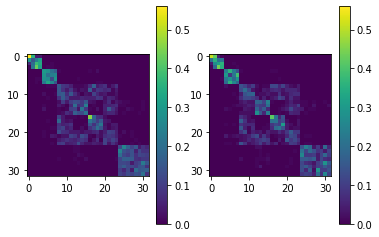

In [21]:
fig, ax = plt.subplots(1, 2)
vmax = np.max([cm1_rs.max(), cm2_rs.max()])
im = ax[0].imshow(cm1_rs, vmax=vmax, vmin=0)
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(cm2_rs, vmax = vmax, vmin=0)
plt.colorbar(im, ax=ax[1])
print(np.corrcoef(cm1_rs.flatten(), cm2_rs.flatten())[0, 1])

In [83]:
half_dict = {'trues': trues, 'pred1': pred1, 'pred2': pred2}
pickle.dump(half_dict, open('230425_half_dict.p', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
### Another metric for the difference between two confusion matrices - the dot product
def dp(cm1, cm2):
    return np.dot(cm1.flatten(), cm2.flatten())/(np.linalg.norm(cm1.flatten())*np.linalg.norm(cm2.flatten()))
print(dp(cm1_rs, cm2_rs), np.arccos(dp(cm1_rs, cm2_rs)))

### So the two confusion matrices are very similar

NameError: name 'cm1_rs' is not defined

In [45]:
### Now we look at the full weighting with varying number of repeats
[i.fit() for i in diff_models1];
[i.fit() for i in onset_models1];
[i.fit() for i in conc_models1];
[i.fit() for i in diff_models2];
[i.fit() for i in diff_models3];

In [46]:
diff_preds1 = [i.pred_resp for i in diff_models1]
diff_preds2 = [i.pred_resp for i in diff_models2]
diff_preds3 = [i.pred_resp for i in diff_models3]
onset_preds1 = [i.pred_resp for i in onset_models1]
conc_preds1 = [i.pred_resp for i in conc_models1]

In [47]:
def generate_poisson_data(base_data, number_of_reps=5):
    poisson_generated = np.array([[poisson(i).rvs(number_of_reps) for i in j] for j in base_data])
    return poisson_generated

def generate_and_clf(base_data, number_of_reps=5, classifier=RandomForestClassifier, seed=None):
    poisson_generated = generate_poisson_data(base_data, number_of_reps)
    ys = [i for i in range(32) for j in range(number_of_reps)]
    X_train, X_test, y_train, y_test = train_test_split(poisson_generated.reshape(130, -1).T, ys, test_size=32, random_state=seed, stratify=ys)
    clf = classifier()
    clf.fit(X_train, y_train)
    return poisson_generated, y_test, clf.predict(X_test)

In [48]:
diff_preds_scattered1 = dasked.client.scatter(diff_preds1)
diff_preds_scattered2 = dasked.client.scatter(diff_preds2)
diff_preds_scattered3 = dasked.client.scatter(diff_preds3)
onset_preds_scattered1 = dasked.client.scatter(onset_preds1)
conc_preds_scattered1 = dasked.client.scatter(conc_preds1)


In [49]:
dask_futures = []
for pred_base in [diff_preds_scattered1, diff_preds_scattered2, diff_preds_scattered3, onset_preds_scattered1, conc_preds_scattered1]:
    for i in range(2, 21):
        for j in range(100):
            dask_futures.append(dask.delayed(generate_and_clf)(pred_base, i, RandomForestClassifier))
dask_futures = dasked.client.compute(dask_futures)
dasked.current_futures = dask_futures

In [157]:
import time
from collections import deque
status_dict = {}
while True:
#for i in range(10):
    status = np.array([i.status for i in dasked.current_futures])

    for i in np.unique(status):
        if i not in status_dict:
            status_dict[i] = deque(maxlen=50)
            status_dict[i].append(len(status[status == i]))
        else:
            status_dict[i].append(len(status[status == i]))
    diffs = [np.diff(status_dict[i]) for i in status_dict]
    remaining = status_dict['pending'][-1]
    estimation = np.sum(diffs[0]) / (len(diffs[0])*0.2)
    print(f'{remaining/estimation/60:0.2f} mins, {np.mean(diffs[0])*5:0.2f} ps', end='\r')
    time.sleep(0.2)

/camp/home/warnert/.conda/envs/blip_manu/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/camp/home/warnert/.conda/envs/blip_manu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/camp/home/warnert/.conda/envs/blip_manu/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [ ]:
dasked.check_progress()

finished 9500


In [117]:
res = dasked.collect_results()
res = np.array(res).reshape(5, 19, 100, 3)

In [118]:
generated_ps = res[:, :, :, 0]
trues = res[:, :, :, 1]
preds = res[:, :, :, 2]

In [119]:
fw_all_dict = {'poisson_generated': generated_ps, 'trues': trues, 'preds': preds, 'keys':['diff1', 'diff2', 'diff3', 'onset', 'conc']}
pickle.dump(fw_all_dict, open('230425_fw_all_dict.p', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [125]:
jwms = pickle.Unpickler(open('230405_joint_weighting_models1.pkl', 'rb')).load()
jwms_preds = [i.pred_resp for i in jwms.models]

In [126]:
dask_futures = []
for i in range(2, 21):
    for j in range(100):
        dask_futures.append(dask.delayed(generate_and_clf)(jwms_preds, i, RandomForestClassifier))
dask_futures = dasked.client.compute(dask_futures)
dasked.current_futures = dask_futures

In [146]:
dasked.check_progress()

finished 1900


In [147]:
res = dasked.collect_results()
res = np.array(res).reshape(19, 100, 3)
generated_ps = res[ :, :, 0]
trues = res[:, :, 1]
preds = res[:, :, 2]

In [148]:
sw_dict = {'poisson_generated': generated_ps, 'trues': trues, 'preds': preds}
pickle.dump(sw_dict, open('230425_sw_dict.p', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [149]:
bin_weights1 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models1])
bin_weights2 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models2])
bin_weights3 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models3])

In [150]:
def return_models(bin_weights, base_models, saved_components=1):
    pca = PCA(n_components=9)
    pcad_bw = pca.fit_transform(bin_weights.mean(axis=1))
    pcad_bw[:, saved_components:] = 0
    returned_weights = pca.inverse_transform(pcad_bw)
    returned_models = [copy.deepcopy(i) for i in base_models]
    [i.fit() for i in returned_models]
    threshes = [i.opt_out.x[-1] for i in returned_models]
    joined_weights = [list(returned_weights[i]) + [threshes[i]] for i in range(len(returned_weights))]
    [j.fit(W=joined_weights[i]) for i, j in enumerate(returned_models)]
    return returned_models


### Makes models with x components for each bin from each PC
all_returned_models1 = [return_models(bin_weights1, diff_models1, i) for i in trange(9)]
all_returned_models2 = [return_models(bin_weights2, diff_models2, i) for i in trange(9)]
all_returned_models3 = [return_models(bin_weights3, diff_models3, i) for i in trange(9)]


100%|██████████| 9/9 [00:27<00:00,  3.08s/it]


In [151]:
all_returned_preds1 = [[i.pred_resp for i in models] for models in all_returned_models1]
all_returned_preds2 = [[i.pred_resp for i in models] for models in all_returned_models2]
all_returned_preds3 = [[i.pred_resp for i in models] for models in all_returned_models3]

In [152]:
all_returned_preds_scattered1 = [[dasked.client.scatter(i) for i in models] for models in all_returned_preds1]
all_returned_preds_scattered2 = [[dasked.client.scatter(i) for i in models] for models in all_returned_preds2]
all_returned_preds_scattered3 = [[dasked.client.scatter(i) for i in models] for models in all_returned_preds3]


In [153]:
dask_futures = []
for odour in [all_returned_preds_scattered1, all_returned_preds_scattered2, all_returned_preds_scattered3]:
    for i in range(9):
        for rep_num in range(2, 21):
            for j in range(100):
                dask_futures.append(dask.delayed(generate_and_clf)(odour[i], rep_num, RandomForestClassifier))
dask_futures = dasked.client.compute(dask_futures)
dasked.current_futures = dask_futures

In [158]:
dasked.check_progress()

finished 51300


In [122]:
res = dasked.collect_results()
res = np.array(res).reshape(3, 9, 19, 100, 3)
generated_ps = res[:, :, :, :, 0]
trues = res[:, :, :, :, 1]
preds = res[:, :, :, :, 2]

In [123]:
pcs_all_dict = {'poisson_generated': generated_ps, 'trues': trues, 'preds': preds, 'header':['dim1 = odour', 'dim2 = number of PCs', 'dim3 = number of repets', 'dim4 = classifier repeats']}
pickle.dump(pcs_all_dict, open('230425_pcs_all_dict.p', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

### Loading in the data


In [2]:
half_dict = pickle.Unpickler(open('230425_half_dict.p', 'rb')).load()
fw_dict = pickle.Unpickler(open('230425_fw_all_dict.p', 'rb')).load()
sw_dict = pickle.Unpickler(open('230425_sw_dict.p', 'rb')).load()
pcs_dict = pickle.Unpickler(open('230425_pcs_all_dict.p', 'rb')).load()
true_classifiers = pickle.Unpickler(open('../Fig3/230315_full_classifier_RFs.pkl', 'rb')).load()
preds = true_classifiers[:, :, 1]
preds = np.array([np.hstack(i) for i in preds])
trues = [i for j in range(100) for i in range(32)]
cm_true1 = confusion_matrix(trues, preds[0], labels=range(32), normalize='true')

In [11]:
print(half_dict.keys())

dict_keys(['trues', 'pred1', 'pred2'])


0.9372656124571651


Text(0.5, 0, 'Predicted')

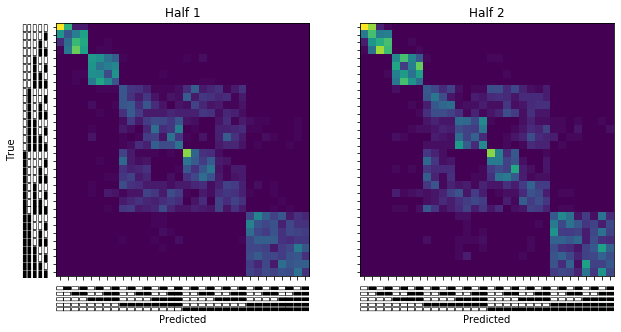

In [30]:
### Two halves of the data confusion matrices - each one is constructed from disctinct data from the other
cm_half1 = confusion_matrix(half_dict['trues'].flatten(), half_dict['pred1'].flatten(), normalize='true', labels=range(32))
cm_half2 = confusion_matrix(half_dict['trues'].flatten(), half_dict['pred2'].flatten(), normalize='true', labels=range(32))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cm_half1)
ax[1].imshow(cm_half2)
print(np.corrcoef(cm_half1.flatten(), cm_half2.flatten())[0, 1])
ax[0].set_title('Half 1')
ax[1].set_title('Half 2')
ax[0].set_xticks(range(32))
ax[0].set_yticks(range(32))
ax[1].set_xticks(range(32))
ax[1].set_yticks(range(32))
ax[0].set_xticklabels(glyphs, rotation=90)
ax[0].set_yticklabels(glyphs)
ax[1].set_xticklabels(glyphs, rotation=90)
ax[1].set_yticklabels([])
ax[0].set_ylim(31.5, -0.5)
ax[1].set_ylim(31.5, -0.5)
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[1].set_xlabel('Predicted')

In [3]:
def find_correlation_between_cm(preds, trues):
    corrs = []
    cms = []
    for true_reps, pred_reps in zip(trues,preds):
        cm_pred = confusion_matrix(np.concatenate(true_reps), np.concatenate(pred_reps), labels=range(32), normalize='true')
        corr = np.corrcoef(cm_pred.flatten(), cm_true1.flatten())[0, 1]
        corrs.append(corr)
        cms.append(cm_pred)
    return corrs, cms

In [4]:
corrs_diff1, cms_diffs1 = find_correlation_between_cm(fw_dict['preds'][0], fw_dict['trues'][0])
corrs_diff2, cms_diffs2 = find_correlation_between_cm(fw_dict['preds'][1], fw_dict['trues'][1])
corrs_diff3, cms_diffs3 = find_correlation_between_cm(fw_dict['preds'][2], fw_dict['trues'][2])
corrs_onset, cms_onset = find_correlation_between_cm(fw_dict['preds'][3], fw_dict['trues'][3])
corrs_conc, cms_conc = find_correlation_between_cm(fw_dict['preds'][4], fw_dict['trues'][4])

corrs_sw, cms_sw = find_correlation_between_cm(sw_dict['preds'], sw_dict['trues'])
print(pcs_dict['header'])

['dim1 = odour', 'dim2 = number of PCs', 'dim3 = number of repets', 'dim4 = classifier repeats']


In [6]:
corrs_pc1, cms_pc1 = [], []
for i in range(9):
    corr_pc1, cm_pc1 = find_correlation_between_cm(pcs_dict['preds'][0][i], pcs_dict['trues'][0][i])
    corrs_pc1.append(corr_pc1)
    cms_pc1.append(cm_pc1)

Text(0.5, 1.0, 'PCs confusion matrix correlation')

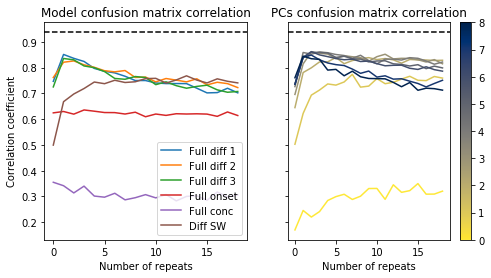

In [34]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))

self_corr = np.corrcoef(cm_half1.flatten(), cm_half2.flatten())[0, 1]

ax[0].plot(corrs_diff1, label='Full diff 1')
ax[0].plot(corrs_diff2, label='Full diff 2')
ax[0].plot(corrs_diff3, label='Full diff 3')
ax[0].plot(corrs_onset, label='Full onset')
ax[0].plot(corrs_conc, label='Full conc')
ax[0].plot(corrs_sw, label='Diff SW')
colors = matplotlib.cm.cividis_r(np.linspace(0, 1, len(corrs_pc1)))
[ax[1].plot(i, color=j) for i, j in zip(corrs_pc1, colors)]
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(corrs_pc1) - 1)
sm = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.cividis_r, norm=norm)
sm.set_array([])
plt.colorbar(sm,ax=ax[1])

ax[0].legend()
ax[0].axhline(self_corr, color='k', linestyle='--')
ax[1].axhline(self_corr, color='k', linestyle='--')
ax[0].set_ylabel('Correlation coefficient')
ax[0].set_xlabel('Number of repeats')
ax[1].set_xlabel('Number of repeats')
ax[0].set_title('Model confusion matrix correlation')
ax[1].set_title('PCs confusion matrix correlation')

(31.5, -0.5)

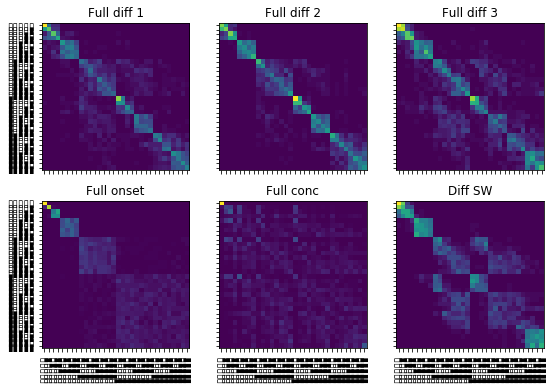

In [116]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9, 6))
ax = ax.flatten()
corrs_list = [corrs_diff1, corrs_diff2, corrs_diff3, corrs_onset, corrs_conc, corrs_sw]
cms_list = [cms_diffs1, cms_diffs2, cms_diffs3, cms_onset, cms_conc, cms_sw]
titles = ['Full diff 1', 'Full diff 2', 'Full diff 3', 'Full onset', 'Full conc', 'Diff SW']
for index, (corr, cms) in enumerate(zip(corrs_list, cms_list)):
    max_corr = np.argmax(corr)
    ax[index].imshow(cms[max_corr])
    ax[index].set_title(titles[index])
ax[0].set_yticks(range(32))
ax[0].set_yticklabels(glyphs)
ax[3].set_xticks(range(32))
ax[3].set_xticklabels(glyphs, rotation=90);
ax[4].set_xticklabels(glyphs, rotation=90);
ax[5].set_xticklabels(glyphs, rotation=90);
ax[0].set_ylim(31.5, -0.5)

In [122]:
print(len(cms_pc1))

9


(31.5, -0.5)

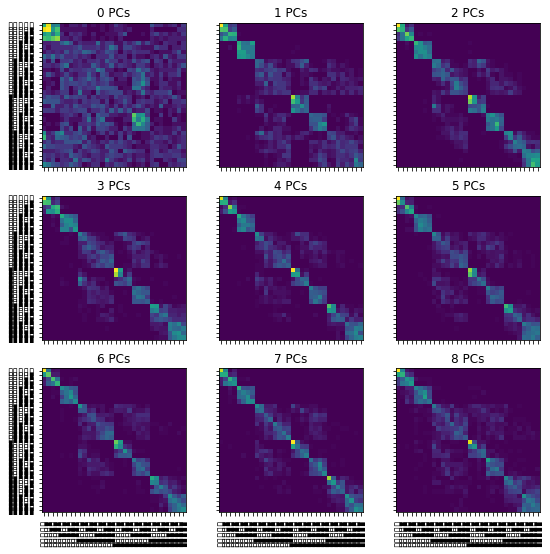

In [12]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 9))
ax = ax.flatten()
titles = [f'{i} PCs' for i in range(9)]
for index, (corr, cms) in enumerate(zip(corrs_pc1, cms_pc1)):
    max_corr = np.argmax(corr)
    ax[index].imshow(cms[max_corr])

    ax[index].set_title(titles[index])
ax[0].set_yticks(range(32))
ax[0].set_yticklabels(glyphs)
ax[3].set_xticks(range(32))
ax[6].set_xticklabels(glyphs, rotation=90);
ax[7].set_xticklabels(glyphs, rotation=90);
ax[8].set_xticklabels(glyphs, rotation=90);
ax[0].set_ylim(31.5, -0.5)

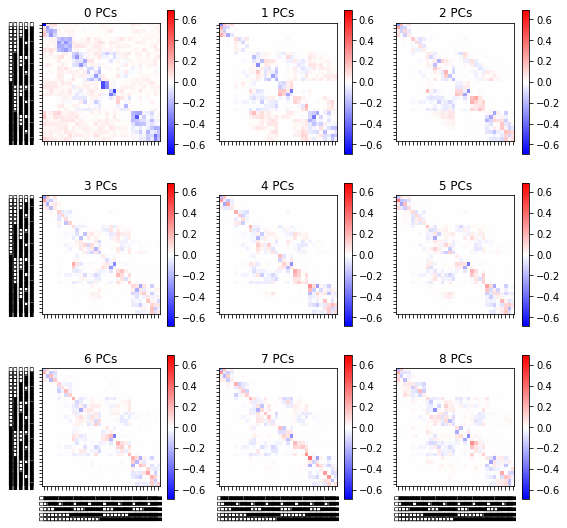

In [15]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 9))
ax = ax.flatten()
global_vmax = True

summed_fit_error = []
titles = [f'{i} PCs' for i in range(9)]
vmaxs = []
ims = []
for index, (corr, cms) in enumerate(zip(corrs_pc1, cms_pc1)):
    max_corr = np.argmax(corr)
    diff_cm = cms[max_corr] - cm_true1
    vmax = np.max(np.abs(diff_cm))
    im = ax[index].imshow(diff_cm, cmap='bwr', vmin=-vmax, vmax=vmax)
    summed_fit_error.append(np.sum(np.abs(diff_cm)))
    ax[index].set_title(titles[index])
    plt.colorbar(im, ax=ax[index])
    vmaxs.append(vmax)
    ims.append(im)
ax[0].set_yticks(range(32))
ax[0].set_yticklabels(glyphs)
ax[3].set_xticks(range(32))
ax[6].set_xticklabels(glyphs, rotation=90);
ax[7].set_xticklabels(glyphs, rotation=90);
ax[8].set_xticklabels(glyphs, rotation=90);
ax[0].set_ylim(31.5, -0.5)
vmax = np.max(vmaxs)
[i.set_clim(vmin=-vmax, vmax=vmax) for i in ims]
plt.draw_all()

Text(0, 0.5, 'Summed absolute error')

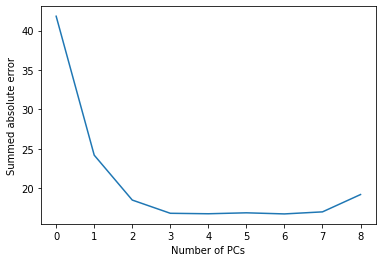

In [40]:
plt.plot(summed_fit_error)
plt.xlabel('Number of PCs')
plt.ylabel('Summed absolute error')

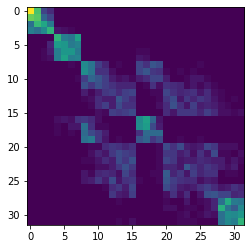

In [71]:
cm_jw = confusion_matrix(np.concatenate(sw_dict['trues'][10]), np.concatenate(sw_dict['preds'][10]), labels=range(32), normalize='true')
plt.imshow(cm_jw)

In [67]:
print(s)

[ 2  7 19 ... 11 14 10]


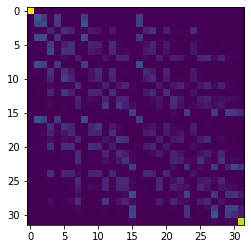

In [15]:
cm = confusion_matrix(np.concatenate(fw_dict['trues'][4][4]), np.concatenate(fw_dict['preds'][4][4]), labels=range(32), normalize='true')
plt.imshow(cm)